# Problem Statement


### Customer Churn:

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.


### Data Understanding:

Postpaid: When customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

Prepaid: customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

### Churn Definition:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

#### Agenda: If you define churn based on a ~‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

### Customer Behaviour During Churn:

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.


The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

# Task:


#### Derive new features:

This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models. Use your business understanding to derive features you think could be important indicators of churn.

#### Filter high-value customers

As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

#### Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9


After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

# Data Dictionary

|Acronyms| Descriptions|
| --- | --- |
|MOBILE_NUMBER|Customer phone number|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls - within same telecom circle|
|STD|STD calls - outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|"Operator T to T| i.e. within same operator (mobile to mobile)"|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to it?s own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage - voice calls|
|AON    |Age on network - number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |3G network|
|AV    |Average|
|VOL    |Mobile internet usage volume (in MB)|
|2G    |2G network|
|PCK    |Prepaid service schemes called - PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|*.9    |KPI for the month of September|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost - when no specific scheme is not purchased and paid as per usage|

# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy
import math
sns.set_style("dark")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
import datetime as dt
from numba import njit
from scipy.stats import chisquare
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from yellowbrick.classifier import roc_auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier

C:\Users\lette\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Understanding Data

In [4]:
df = pd.read_csv('telecom_churn_data (2).csv')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [16]:
# Shape of the data
df.shape

(99999, 226)

In [7]:
# Number of user data:
# The 'mobile_number' feature we can drop as has unique values at each row
print("Number of unique Users: ",len(df['mobile_number'].unique()))
df.drop('mobile_number', axis=1, inplace=True)

Number of unique Users:  99999


In [36]:
a = list(df)
a.sort()
for x in a:
    print(x)

aon
arpu_2g_6
arpu_2g_7
arpu_2g_8
arpu_2g_9
arpu_3g_6
arpu_3g_7
arpu_3g_8
arpu_3g_9
arpu_6
arpu_7
arpu_8
arpu_9
aug_vbc_3g
av_rech_amt_data_6
av_rech_amt_data_7
av_rech_amt_data_8
av_rech_amt_data_9
count_rech_2g_6
count_rech_2g_7
count_rech_2g_8
count_rech_2g_9
count_rech_3g_6
count_rech_3g_7
count_rech_3g_8
count_rech_3g_9
date_of_last_rech_6
date_of_last_rech_7
date_of_last_rech_8
date_of_last_rech_9
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8
date_of_last_rech_data_9
fb_user_6
fb_user_7
fb_user_8
fb_user_9
ic_others_6
ic_others_7
ic_others_8
ic_others_9
isd_ic_mou_6
isd_ic_mou_7
isd_ic_mou_8
isd_ic_mou_9
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
isd_og_mou_9
jul_vbc_3g
jun_vbc_3g
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
last_day_rch_amt_6
last_day_rch_amt_7
last_day_rch_amt_8
last_day_rch_amt_9
loc_ic_mou_6
loc_ic_mou_7
loc_ic_mou_8
loc_ic_mou_9
loc_ic_t2f_mou_6
loc_ic_t2f_mou_7
loc_ic_t2f_mou_8
loc_ic_t2f_mou_9

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 221 entries, loc_og_t2o_mou to sep_vbc_3g
dtypes: float64(179), int64(33), object(9)
memory usage: 168.6+ MB


In [8]:
# Lets see what this 'circle_id', look like
# As there are only one unique value in the feature, we can dropping the feature
print('Unique values in "circle_id" ',df['circle_id'].unique())
df.drop('circle_id', axis=1, inplace=True)

Unique values in "circle_id"  [109]


In [62]:
# Lets check the missing values in the dataframe
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing_Values', 1 : 'Per_of_Total_Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    'Per_of_Total_Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_value = missing_values_table(df)
missing_value

Your selected dataframe has 224 columns.
There are 166 columns that have missing values.


,Missing_Values,Per_of_Total_Values
count_rech_2g_6,74846,74.8
max_rech_data_6,74846,74.8
arpu_3g_6,74846,74.8
av_rech_amt_data_6,74846,74.8
count_rech_3g_6,74846,74.8
...,...,...
last_date_of_month_8,1100,1.1
std_og_t2o_mou,1018,1.0
loc_ic_t2o_mou,1018,1.0
loc_og_t2o_mou,1018,1.0


**Missing Value Analysis**<br>
As per this analysis, some of the column has missing values more than 30 %. <br>
However we will not be able to remove those.<br>
Eg:- Feature 'count_rech_2g_6' means if the user has recharged for any 2G pack, the user might use 3G or 4G handset. <br>
Hence we need to go through features and analyze how we can impute the missing values.<br>

# Taking care of Missing Values

In [64]:
missing_value[missing_value.Per_of_Total_Values>70].shape

(40, 2)

In [71]:
missing_value[missing_value.Per_of_Total_Values>70].sort_index()

,Missing_Values,Per_of_Total_Values
arpu_2g_6,74846,74.8
arpu_2g_7,74428,74.4
arpu_2g_8,73660,73.7
arpu_2g_9,74077,74.1
arpu_3g_6,74846,74.8
arpu_3g_7,74428,74.4
arpu_3g_8,73660,73.7
arpu_3g_9,74077,74.1
av_rech_amt_data_6,74846,74.8
av_rech_amt_data_7,74428,74.4


In [77]:
# From what i could see that all the features are with missing values greater than 70 %, are feature based.
# Like if thte user has availed the service we have a data, otherwise the data is missing.
# We can easily fill the nan for these columns with '0', meaning that the feature has not been used. 
col_nan_more_than_70 = list(missing_value[missing_value.Per_of_Total_Values>70].index)
df[col_nan_more_than_70] = df[col_nan_more_than_70].replace(to_replace=np.nan, value=0)

In [79]:
# Validade our findings
missing_value = missing_values_table(df)
missing_value[missing_value.Per_of_Total_Values>70].sort_index()

Your selected dataframe has 224 columns.
There are 126 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [84]:
# Taking care of the remaining missing values
missing_value.sort_values('Per_of_Total_Values',ascending=False)

,Missing_Values,Per_of_Total_Values
loc_og_t2f_mou_9,7745,7.7
loc_ic_t2t_mou_9,7745,7.7
loc_og_t2t_mou_9,7745,7.7
std_ic_t2t_mou_9,7745,7.7
std_og_t2c_mou_9,7745,7.7
...,...,...
last_date_of_month_8,1100,1.1
std_og_t2o_mou,1018,1.0
loc_ic_t2o_mou,1018,1.0
loc_og_t2o_mou,1018,1.0


In [92]:
missing_value[missing_value.Per_of_Total_Values>6].sort_index().shape

(29, 2)

In [93]:
missing_value[missing_value.Per_of_Total_Values>6].sort_index()

,Missing_Values,Per_of_Total_Values
ic_others_9,7745,7.7
isd_ic_mou_9,7745,7.7
isd_og_mou_9,7745,7.7
loc_ic_mou_9,7745,7.7
loc_ic_t2f_mou_9,7745,7.7
loc_ic_t2m_mou_9,7745,7.7
loc_ic_t2t_mou_9,7745,7.7
loc_og_mou_9,7745,7.7
loc_og_t2c_mou_9,7745,7.7
loc_og_t2f_mou_9,7745,7.7


In [95]:
# Similar to the missing value segment above 70%, all the features here are mostly special feature based.
# If a user is not availing the feature, we can assign it to be as 0.
col_nan_more_than_6 = list(missing_value[missing_value.Per_of_Total_Values>6].index)
df[col_nan_more_than_6] = df[col_nan_more_than_6].replace(to_replace=np.nan, value=0)

In [96]:
# Validade our findings
missing_value = missing_values_table(df)
missing_value[missing_value.Per_of_Total_Values>6].sort_index()

Your selected dataframe has 224 columns.
There are 97 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [97]:
# Taking care of the remaining missing values
missing_value.sort_values('Per_of_Total_Values',ascending=False)

,Missing_Values,Per_of_Total_Values
std_og_t2c_mou_8,5378,5.4
loc_og_t2c_mou_8,5378,5.4
ic_others_8,5378,5.4
std_og_mou_8,5378,5.4
isd_ic_mou_8,5378,5.4
...,...,...
last_date_of_month_8,1100,1.1
std_og_t2o_mou,1018,1.0
loc_ic_t2o_mou,1018,1.0
loc_og_t2o_mou,1018,1.0


In [110]:
missing_value[missing_value.Per_of_Total_Values>4].sort_index()

,Missing_Values,Per_of_Total_Values
date_of_last_rech_9,4760,4.8
ic_others_8,5378,5.4
isd_ic_mou_8,5378,5.4
isd_og_mou_8,5378,5.4
loc_ic_mou_8,5378,5.4
loc_ic_t2f_mou_8,5378,5.4
loc_ic_t2m_mou_8,5378,5.4
loc_ic_t2t_mou_8,5378,5.4
loc_og_mou_8,5378,5.4
loc_og_t2c_mou_8,5378,5.4


In [111]:
# Similar to the missing value segment above 70%, all the features here are mostly special feature based.
# If a user is not availing the feature, we can assign it to be as 0.
col_nan_more_than_4 = list(missing_value[missing_value.Per_of_Total_Values>4].index)
df[col_nan_more_than_4] = df[col_nan_more_than_4].replace(to_replace=np.nan, value=0)

In [112]:
# Validade our findings
missing_value = missing_values_table(df)
missing_value[missing_value.Per_of_Total_Values>6].sort_index()

Your selected dataframe has 224 columns.
There are 67 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [116]:
missing_value[missing_value.Per_of_Total_Values>3].sort_index()

,Missing_Values,Per_of_Total_Values
date_of_last_rech_8,3622,3.6
ic_others_6,3937,3.9
ic_others_7,3859,3.9
isd_ic_mou_6,3937,3.9
isd_ic_mou_7,3859,3.9
isd_og_mou_6,3937,3.9
isd_og_mou_7,3859,3.9
loc_ic_mou_6,3937,3.9
loc_ic_mou_7,3859,3.9
loc_ic_t2f_mou_6,3937,3.9


In [117]:
# Similar to the missing value segment above 70%, all the features here are mostly special feature based.
# If a user is not availing the feature, we can assign it to be as 0.
col_nan_more_than_3 = list(missing_value[missing_value.Per_of_Total_Values>3].index)
df[col_nan_more_than_3] = df[col_nan_more_than_3].replace(to_replace=np.nan, value=0)

In [118]:
# Validade our findings
missing_value = missing_values_table(df)
missing_value[missing_value.Per_of_Total_Values>3].sort_index()

Your selected dataframe has 224 columns.
There are 8 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [119]:
missing_value[missing_value.Per_of_Total_Values<3].sort_index()

,Missing_Values,Per_of_Total_Values
date_of_last_rech_6,1607,1.6
date_of_last_rech_7,1767,1.8
last_date_of_month_7,601,0.6
last_date_of_month_8,1100,1.1
last_date_of_month_9,1659,1.7
loc_ic_t2o_mou,1018,1.0
loc_og_t2o_mou,1018,1.0
std_og_t2o_mou,1018,1.0


In [125]:
# last_date_of_month_7, last_date_of_month_8 and last_date_of_month_9
# These are not required, as the dates will not count anything in our model
df.drop(['last_date_of_month_7','last_date_of_month_8', 'last_date_of_month_9'],axis=1,inplace=True)

In [126]:
missing_value[missing_value.Per_of_Total_Values<3].sort_index()

,Missing_Values,Per_of_Total_Values
date_of_last_rech_6,1607,1.6
date_of_last_rech_7,1767,1.8
last_date_of_month_7,601,0.6
last_date_of_month_8,1100,1.1
last_date_of_month_9,1659,1.7
loc_ic_t2o_mou,1018,1.0
loc_og_t2o_mou,1018,1.0
std_og_t2o_mou,1018,1.0


In [128]:
missing_value = missing_values_table(df)

Your selected dataframe has 221 columns.
There are 5 columns that have missing values.


In [129]:
# Similar to the missing value segment above 70%, all the features here are mostly special feature based.
# If a user is not availing the feature, we can assign it to be as 0.
col_nan_less_than_3 = list(missing_value[missing_value.Per_of_Total_Values<3].index)
df[col_nan_less_than_3] = df[col_nan_less_than_3].replace(to_replace=np.nan, value=0)

In [130]:
# Validade our findings
missing_value = missing_values_table(df)
missing_value[missing_value.Per_of_Total_Values>3].sort_index()

Your selected dataframe has 221 columns.
There are 0 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [132]:
# Saving progress in pickle
df.to_pickle("no_null_1.pkl")

In [3]:
df = pd.read_pickle("no_null_1.pkl")

In [4]:
df.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,0.0,0.0,0.0,6/30/2014,197.385,214.816,213.803,21.100,0.00,0.00,...,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,0.0,0.0,0.0,6/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,...,0,0.0,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00
2,0.0,0.0,0.0,6/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,...,0,0.0,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00
3,0.0,0.0,0.0,6/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,...,0,0.0,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00
4,0.0,0.0,0.0,6/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,...,0,0.0,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 221 entries, loc_og_t2o_mou to sep_vbc_3g
dtypes: float64(179), int64(33), object(9)
memory usage: 168.6+ MB


# Date Work

In [13]:
df.select_dtypes(include='object').head()

,last_date_of_month_6,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9
0,6/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,0,7/31/2014,8/31/2014,9/30/2014
1,6/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,0,7/25/2014,8/10/2014,0,7/31/2014,8/31/2014,9/30/2014
2,6/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,0,0,0,9/17/2014,7/31/2014,8/31/2014,9/30/2014
3,6/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,0,0,0,0,7/31/2014,8/31/2014,9/30/2014
4,6/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,0,0,0,7/31/2014,8/31/2014,9/30/2014


In [41]:
# Creating new features, days_remaining_in_month_from_last_recharge
df['days_remaining_in_month_from_last_recharge_6']=((pd.to_datetime(df['last_date_of_month_6']) - pd.to_datetime(df['date_of_last_rech_6'])).apply(lambda x: x.value))/(24*60*60*(10**9))
df['days_remaining_in_month_from_last_recharge_7']=((pd.to_datetime(df['last_date_of_month_7']) - pd.to_datetime(df['date_of_last_rech_7'])).apply(lambda x: x.value))/(24*60*60*(10**9))
df['days_remaining_in_month_from_last_recharge_8']=((pd.to_datetime(df['last_date_of_month_8']) - pd.to_datetime(df['date_of_last_rech_8'])).apply(lambda x: x.value))/(24*60*60*(10**9))
df['days_remaining_in_month_from_last_recharge_9']=((pd.to_datetime(df['last_date_of_month_9']) - pd.to_datetime(df['date_of_last_rech_9'])).apply(lambda x: x.value))/(24*60*60*(10**9))

In [43]:
# last_date_of_month_6,last_date_of_month_7, last_date_of_month_8 and last_date_of_month_9
# These are not required, as the dates will not count anything in our model
df.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8', 'last_date_of_month_9'],axis=1,inplace=True)

In [61]:
df['days_remaining_in_month_from_last_recharge_6'].values[df['days_remaining_in_month_from_last_recharge_6'].values > 30] = 0

In [64]:
df['days_remaining_in_month_from_last_recharge_7'].values[df['days_remaining_in_month_from_last_recharge_7'].values > 30] = 0
df['days_remaining_in_month_from_last_recharge_8'].values[df['days_remaining_in_month_from_last_recharge_8'].values > 30] = 0
df['days_remaining_in_month_from_last_recharge_9'].values[df['days_remaining_in_month_from_last_recharge_9'].values > 30] = 0

In [65]:
df['days_remaining_in_month_from_last_recharge_6'].values[df['days_remaining_in_month_from_last_recharge_6'].values <0] = 0
df['days_remaining_in_month_from_last_recharge_7'].values[df['days_remaining_in_month_from_last_recharge_7'].values <0] = 0
df['days_remaining_in_month_from_last_recharge_8'].values[df['days_remaining_in_month_from_last_recharge_8'].values <0] = 0
df['days_remaining_in_month_from_last_recharge_9'].values[df['days_remaining_in_month_from_last_recharge_9'].values <0] = 0

In [69]:
df.select_dtypes(include='object').head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,0
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014,0,7/25/2014,8/10/2014,0
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014,0,0,0,9/17/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014,0,0,0,0
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,0,0,0


# Feature Analysis

In [4]:
cols = list(df)
cols.sort()
cols

['aon',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'aug_vbc_3g',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'ic_others_9',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'last_date_of_month_6',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',


0     968
1    1006
2    1103
3    2491
4    1526
Name: aon, dtype: int64


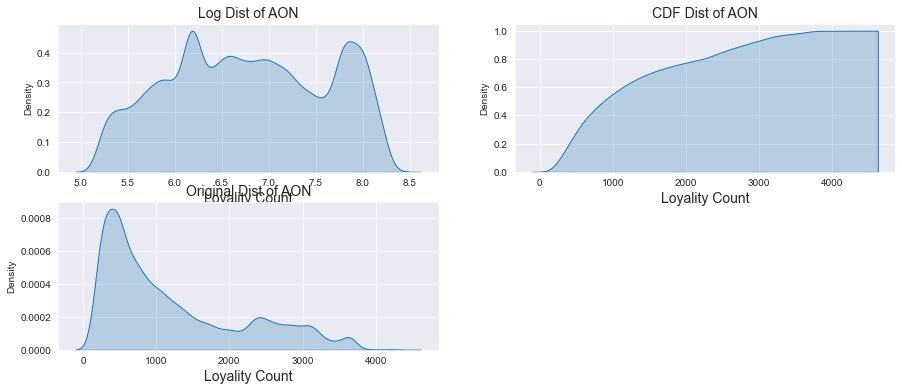

In [61]:
# AON:- Age on network - number of days the customer is using the operator T network
# This feature would be a key role in the model as it shows loyalty
print(df[cols[0]].head())
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(221)
sns.kdeplot(np.log(df[cols[0]]), shade=True, ax=ax1)
plt.xlabel('Loyality Count',size = 14)
plt.title("Log Dist of AON",size = 14)
ax1.grid()

ax2 = plt.subplot(222)
sns.kdeplot(df[cols[0]],shade=True, cumulative=True,ax=ax2)
plt.xlabel('Loyality Count',size = 14)
plt.title('CDF Dist of AON',size = 14)
ax2.grid()
#plt.show()

ax3 = plt.subplot(223)
sns.kdeplot(df[cols[0]],shade=True,cumulative=False,ax=ax3)
plt.xlabel('Loyality Count',size = 14)
plt.title('Original Dist of AON',size = 14)
plt.grid()

plt.show()

In [79]:
# ARPU:- Average revenue per user.
# This shows how much business does a user brings to the company.
# arpu_2g and arpu_3g shows business on these features
# Here as it could be seen, we get the any data above 0, beyond 75%
# Also we see that the min value dips below zero. This could be an indication that the company has taken a loss
# On these customers for that month
df[['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
arpu_2g_6,99999.0,21.731907,94.408718,-35.83,0.0,0.0,0.0,6433.76
arpu_2g_7,99999.0,21.969404,96.746052,-15.48,0.0,0.0,0.0,4809.36
arpu_2g_8,99999.0,22.809665,94.396902,-55.83,0.0,0.0,0.0,3483.17
arpu_2g_9,99999.0,24.292274,96.437504,-45.74,0.0,0.0,0.0,3467.17
arpu_3g_6,99999.0,22.526009,104.360309,-30.82,0.0,0.0,0.0,6362.28
arpu_3g_7,99999.0,22.856642,106.457258,-26.04,0.0,0.0,0.0,4980.90
arpu_3g_8,99999.0,24.014520,104.593649,-24.49,0.0,0.0,0.0,3716.90
arpu_3g_9,99999.0,25.990724,118.562650,-71.09,0.0,0.0,0.0,13884.31


In [102]:
df[['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].quantile(np.linspace(.1, 1, 9, 0))

,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9
0.1,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.2,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.3,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.4,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.5,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.6,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.7,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.8,0.000,0.0,0.00,0.00,0.00,0.00,0.000,0.000
0.9,35.216,34.6,39.26,51.49,21.91,21.91,29.822,38.956


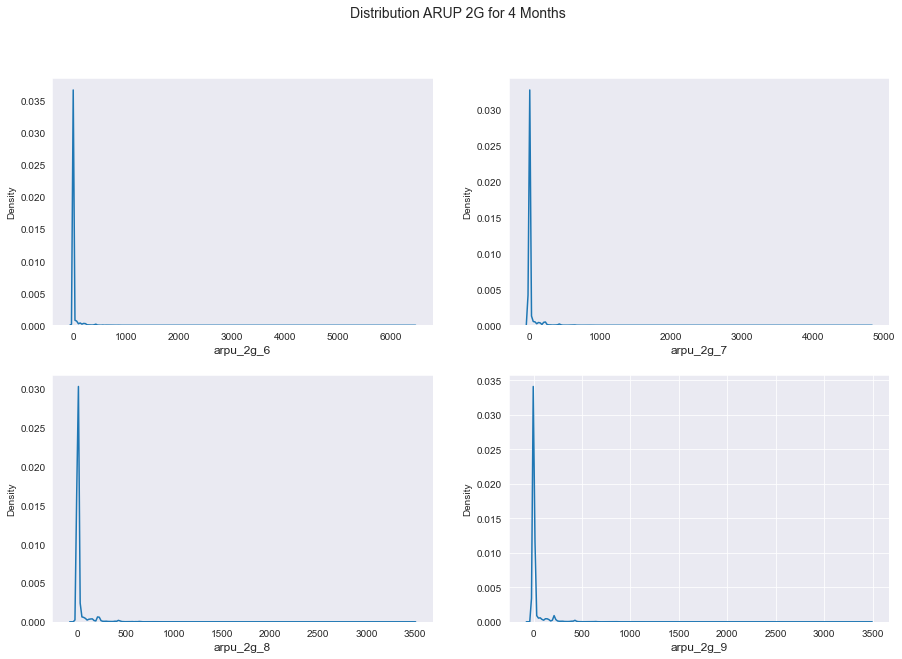

In [76]:
# Lets check the distribution on these.
# arpu_2g for each months
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
ax1 = plt.subplot(221)
sns.kdeplot(df['arpu_2g_6'],ax=ax1)
plt.xlabel("arpu_2g_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['arpu_2g_7'],ax=ax2)
plt.xlabel("arpu_2g_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['arpu_2g_8'],ax=ax3)
plt.xlabel('arpu_2g_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['arpu_2g_9'],ax=ax4)
plt.xlabel('arpu_2g_9',size=12)
plt.grid()
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
plt.show()

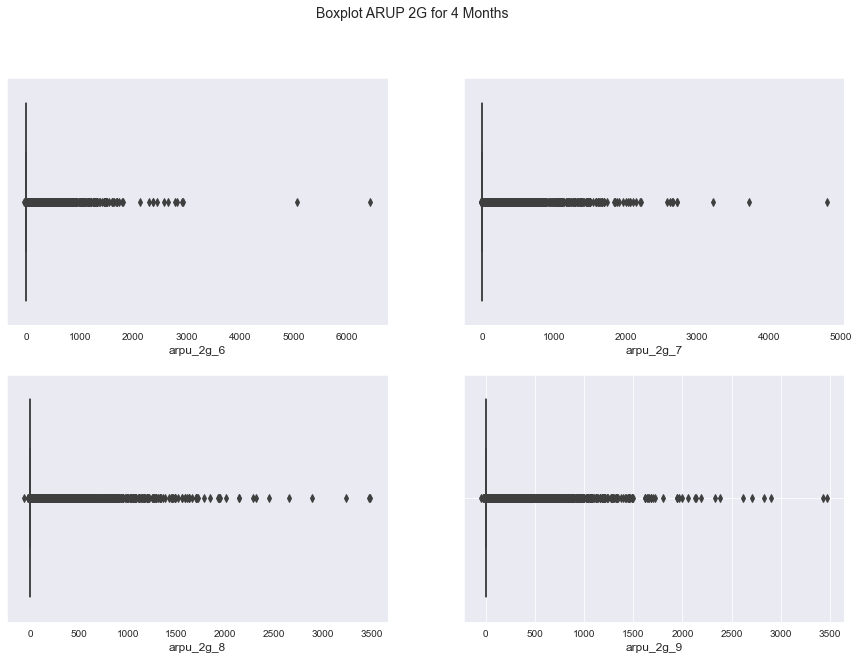

In [85]:
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(221)
sns.boxplot(x=df['arpu_2g_6'],ax=ax1)
plt.xlabel("arpu_2g_6",size=12)
ax2 = plt.subplot(222)
sns.boxplot(x=df['arpu_2g_7'],ax=ax2)
plt.xlabel("arpu_2g_7",size=12)
ax3 = plt.subplot(223)
sns.boxplot(x=df['arpu_2g_8'],ax=ax3)
plt.xlabel('arpu_2g_8',size=12)
ax4 = plt.subplot(224)
sns.boxplot(x=df['arpu_2g_9'],ax=ax4)
plt.xlabel('arpu_2g_9',size=12)
plt.grid()
plt.suptitle("Boxplot ARUP 2G for 4 Months",size=14)
plt.show()

As it could be seen from above.
Most of the data in this feature is zero. Must be lack of 2G Internet usage in 2014. <br>
However as seeing from the above data, hoping to get the same kind of distribution on the 3G model as well.

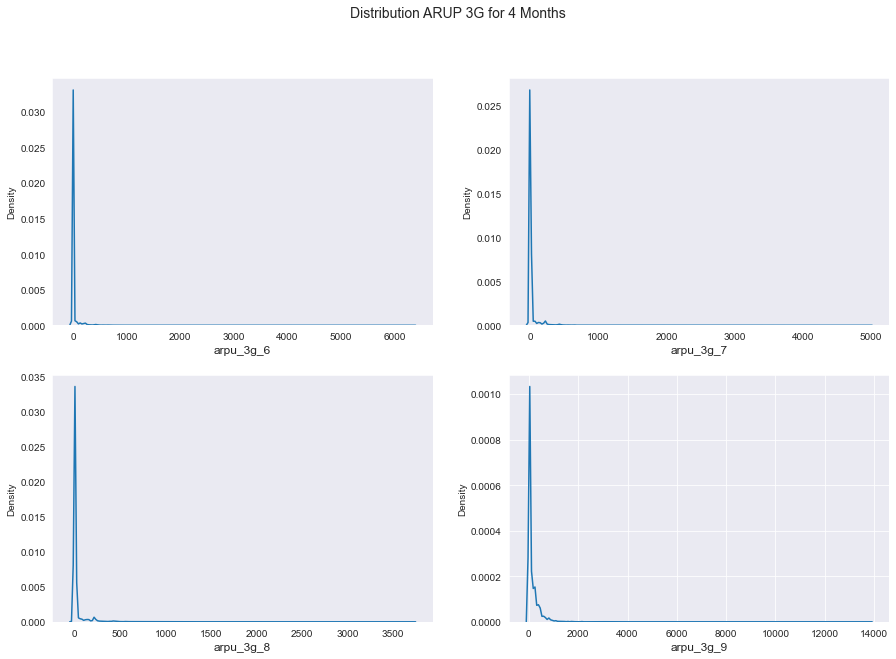

In [84]:
# Lets check the distribution on these.
# arpu_3g for each months
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
ax1 = plt.subplot(221)
sns.kdeplot(df['arpu_3g_6'],ax=ax1)
plt.xlabel("arpu_3g_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['arpu_3g_7'],ax=ax2)
plt.xlabel("arpu_3g_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['arpu_3g_8'],ax=ax3)
plt.xlabel('arpu_3g_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['arpu_3g_9'],ax=ax4)
plt.xlabel('arpu_3g_9',size=12)
plt.grid()
fig.suptitle("Distribution ARUP 3G for 4 Months",size=14)
plt.show()

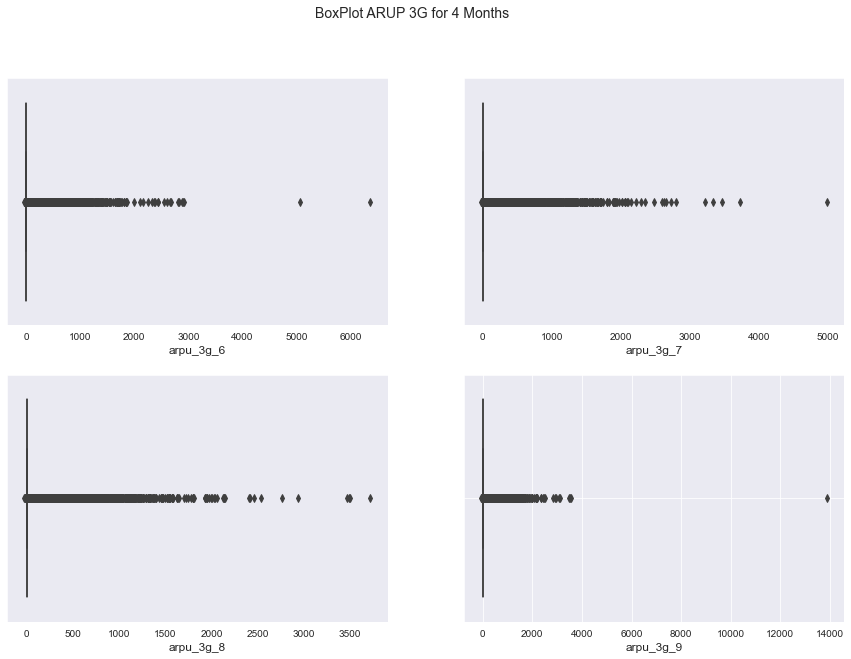

In [82]:
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(221)
sns.boxplot(x=df['arpu_3g_6'],ax=ax1)
plt.xlabel("arpu_3g_6",size=12)
ax2 = plt.subplot(222)
sns.boxplot(x=df['arpu_3g_7'],ax=ax2)
plt.xlabel("arpu_3g_7",size=12)
ax3 = plt.subplot(223)
sns.boxplot(x=df['arpu_3g_8'],ax=ax3)
plt.xlabel('arpu_3g_8',size=12)
ax4 = plt.subplot(224)
sns.boxplot(x=df['arpu_3g_9'],ax=ax4)
plt.xlabel('arpu_3g_9',size=12)
plt.grid()
plt.suptitle("BoxPlot ARUP 3G for 4 Months",size=14)
plt.show()

In [107]:
df[['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']].head()

,arpu_6,arpu_7,arpu_8,arpu_9
0,197.385,214.816,213.803,21.100
1,34.047,355.074,268.321,86.285
2,167.690,189.058,210.226,290.714
3,221.338,251.102,508.054,389.500
4,261.636,309.876,238.174,163.426


In [109]:
# It is seen that ARUP for some users are in negative
df[['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
arpu_6,99999.0,282.987358,328.439770,-2258.709,93.4115,197.704,371.0600,27731.088
arpu_7,99999.0,278.536648,338.156291,-2014.045,86.9805,191.640,365.3445,35145.834
arpu_8,99999.0,279.154731,344.474791,-945.808,84.1260,192.080,369.3705,33543.624
arpu_9,99999.0,261.645069,341.998630,-1899.505,62.6850,176.849,353.4665,38805.617


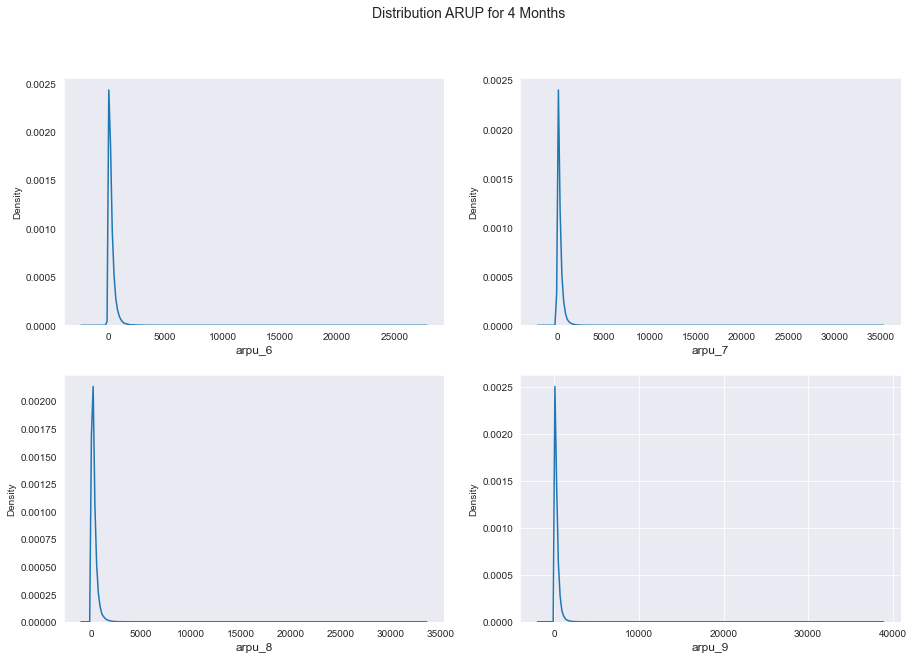

In [111]:
# Lets check the distribution on these.
# arpu for each months
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['arpu_6'],ax=ax1)
plt.xlabel("arpu_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['arpu_7'],ax=ax2)
plt.xlabel("arpu_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['arpu_8'],ax=ax3)
plt.xlabel('arpu_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['arpu_9'],ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
fig.suptitle("Distribution ARUP for 4 Months",size=14)
plt.show()

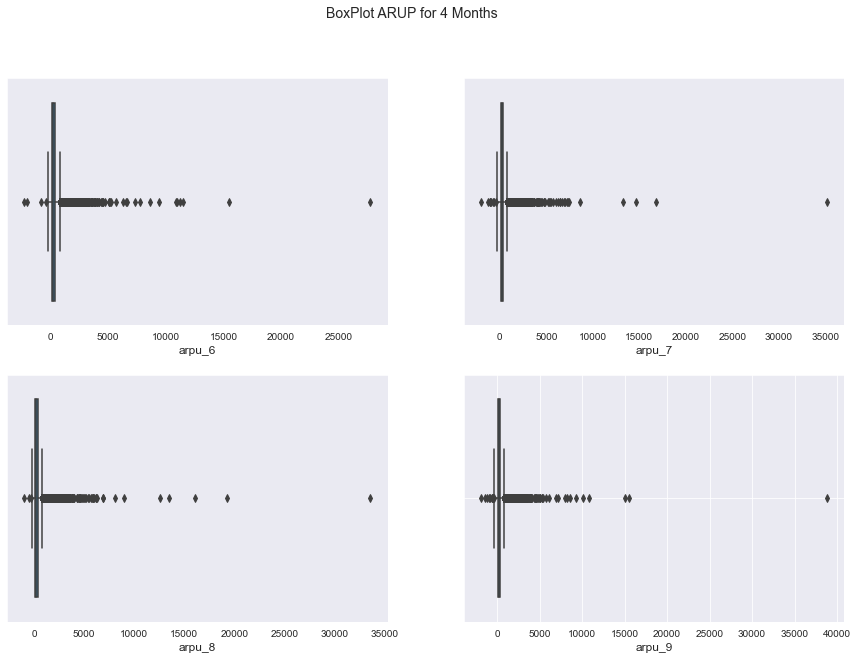

In [112]:
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(221)
sns.boxplot(x=df['arpu_6'],ax=ax1)
plt.xlabel("arpu_6",size=12)
ax2 = plt.subplot(222)
sns.boxplot(x=df['arpu_7'],ax=ax2)
plt.xlabel("arpu_7",size=12)
ax3 = plt.subplot(223)
sns.boxplot(x=df['arpu_8'],ax=ax3)
plt.xlabel('arpu_8',size=12)
ax4 = plt.subplot(224)
sns.boxplot(x=df['arpu_9'],ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
plt.suptitle("BoxPlot ARUP for 4 Months",size=14)
plt.show()

In [121]:
df[['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']].quantile(np.linspace(.01, 1, 40, 0))

,arpu_6,arpu_7,arpu_8,arpu_9
0.01000,0.000000,0.000000,0.000000,0.000000
0.03475,0.000000,0.000000,0.000000,0.000000
0.05950,6.300000,5.318810,0.000000,0.000000
0.08425,23.268484,21.769663,8.258989,0.000000
0.10900,36.768782,34.035782,23.638346,0.968910
0.13375,47.970592,44.151733,36.272733,10.300000
0.15850,58.454098,53.400000,47.224611,23.181147
0.18325,68.058503,62.780634,57.736068,34.573901
0.20800,77.432920,71.708000,67.923584,44.744336
0.23275,86.512811,80.847069,77.796069,55.122742


In [136]:
(df[(df.arpu_6<0)|(df.arpu_7<0)|(df.arpu_8<0)|(df.arpu_9<0)][['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']].shape[0]/df.shape[0])*100

2.133021330213302

In [137]:
(df[(df.arpu_2g_6<0)|(df.arpu_2g_7<0)|(df.arpu_2g_8<0)|(df.arpu_2g_9<0)|(df.arpu_3g_6<0)|(df.arpu_3g_7<0)|(df.arpu_3g_8<0)|(df.arpu_3g_9<0)][['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].shape[0]/df.shape[0])*100

2.6620266202662024

Around 4.8 % of data among the whole dataset has negative value, among these features. We would however have to remove them.
As the average revenue cannot be in negative.

In [153]:
# VBC    	Volume based cost - when no specific scheme is not purchased and paid as per usage
# AUG i belive is for August Month
df['aug_vbc_3g'].describe()

count    99999.000000
mean        68.170248
std        267.580450
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      12916.220000
Name: aug_vbc_3g, dtype: float64

In [147]:
df['aug_vbc_3g'].quantile(np.linspace(.1, 1, 10, 0))

0.10      0.0000
0.19      0.0000
0.28      0.0000
0.37      0.0000
0.46      0.0000
0.55      0.0000
0.64      0.0000
0.73      0.0000
0.82      0.0000
0.91    204.8218
Name: aug_vbc_3g, dtype: float64

<AxesSubplot:xlabel='aug_vbc_3g', ylabel='Density'>

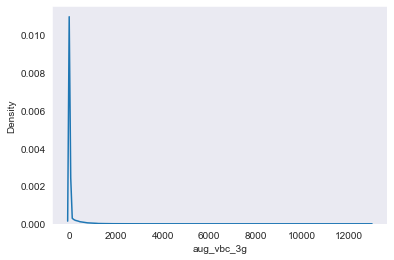

In [151]:
sns.kdeplot(df['aug_vbc_3g'])

In [158]:
list(cols[14:18])

['av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

In [160]:
# Average recharge amount on mobile internet for 4 months
df[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
av_rech_amt_data_6,99999.0,48.445409,127.743863,0.0,0.0,0.0,8.25,7546.0
av_rech_amt_data_7,99999.0,51.393440,132.629365,0.0,0.0,0.0,17.00,4365.0
av_rech_amt_data_8,99999.0,52.027022,131.182609,0.0,0.0,0.0,23.00,4076.0
av_rech_amt_data_9,99999.0,49.961089,127.804280,0.0,0.0,0.0,17.00,4061.0


In [162]:
# Quantile check
df[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9']].quantile(np.linspace(.01, 1, 40, 0))

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
0.01000,0.0,0.0,0.0,0.0
0.03475,0.0,0.0,0.0,0.0
0.05950,0.0,0.0,0.0,0.0
0.08425,0.0,0.0,0.0,0.0
0.10900,0.0,0.0,0.0,0.0
0.13375,0.0,0.0,0.0,0.0
0.15850,0.0,0.0,0.0,0.0
0.18325,0.0,0.0,0.0,0.0
0.20800,0.0,0.0,0.0,0.0
0.23275,0.0,0.0,0.0,0.0


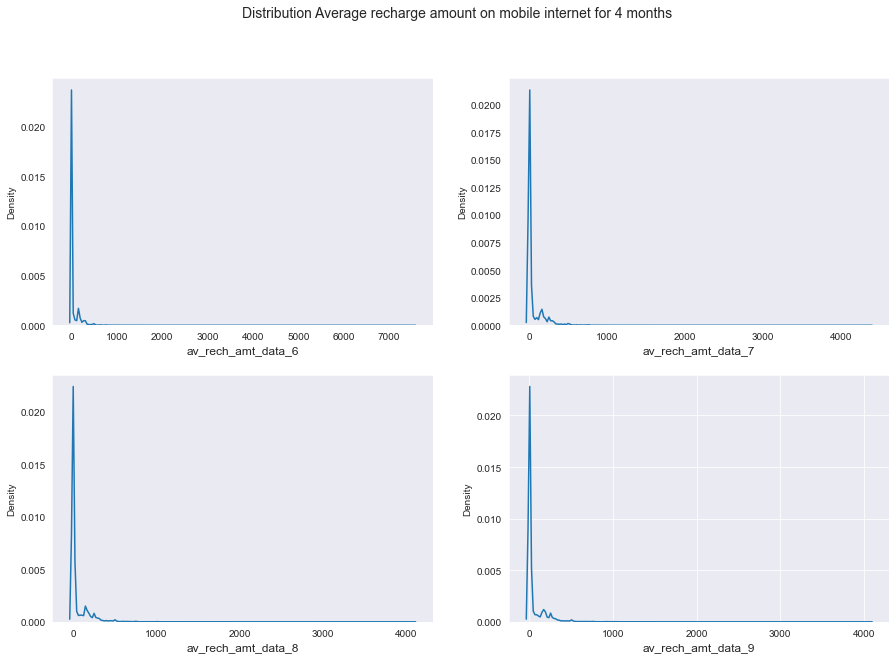

In [164]:
# Lets check the distribution on these.
# arpu for each months
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['av_rech_amt_data_6'],ax=ax1)
plt.xlabel("av_rech_amt_data_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['av_rech_amt_data_7'],ax=ax2)
plt.xlabel("av_rech_amt_data_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['av_rech_amt_data_8'],ax=ax3)
plt.xlabel('av_rech_amt_data_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['av_rech_amt_data_9'],ax=ax4)
plt.xlabel('av_rech_amt_data_9',size=12)
plt.grid()
fig.suptitle("Distribution Average recharge amount on mobile internet for 4 months",size=14)
plt.show()

In [169]:
#cols[14:18]
print(cols[18:26])

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9']


In [171]:
# Count os recharge on 2G and 3G for each month
df[['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
count_rech_2g_6,99999.0,0.469025,1.521915,0.0,0.0,0.0,0.0,42.0
count_rech_2g_7,99999.0,0.522855,1.659925,0.0,0.0,0.0,0.0,48.0
count_rech_2g_8,99999.0,0.531075,1.654565,0.0,0.0,0.0,0.0,44.0
count_rech_2g_9,99999.0,0.461885,1.371526,0.0,0.0,0.0,0.0,40.0
count_rech_3g_6,99999.0,0.150702,0.689999,0.0,0.0,0.0,0.0,29.0
count_rech_3g_7,99999.0,0.158982,0.755537,0.0,0.0,0.0,0.0,35.0
count_rech_3g_8,99999.0,0.167442,0.782059,0.0,0.0,0.0,0.0,45.0
count_rech_3g_9,99999.0,0.170922,0.774557,0.0,0.0,0.0,0.0,49.0


In [172]:
# Quantile check
df[['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9']].quantile(np.linspace(.01, 1, 40, 0))

,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9
0.01000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.03475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.05950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.08425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.10900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.15850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.18325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.20800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.23275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Skipping the date columns for now,  
cols[26:34]

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [12]:
#cols[34:38]
# This social Media packs are of categorical type
df[['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
fb_user_6,99999.0,0.230002,0.420836,0.0,0.0,0.0,0.0,1.0
fb_user_7,99999.0,0.232382,0.422354,0.0,0.0,0.0,0.0,1.0
fb_user_8,99999.0,0.234632,0.423771,0.0,0.0,0.0,0.0,1.0
fb_user_9,99999.0,0.223182,0.416382,0.0,0.0,0.0,0.0,1.0


C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-

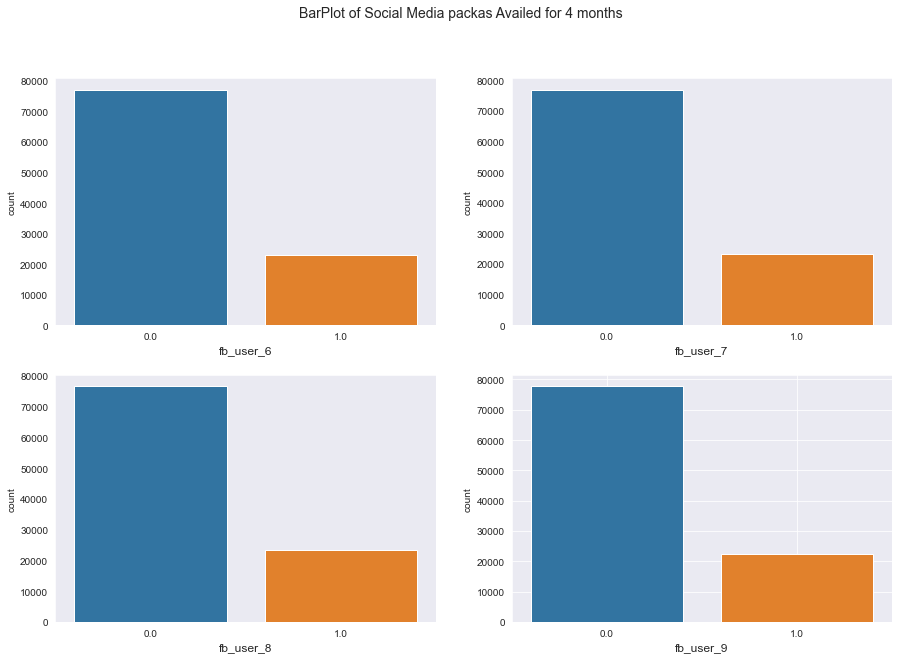

In [14]:
# As observed from below, the user strength seems to be constant with these packs 
# Also it could be see that much less users avail this offer, as compaired to the the users not availing it.
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.countplot(df['fb_user_6'],ax=ax1)
plt.xlabel("fb_user_6",size=12)
ax2 = plt.subplot(222)
sns.countplot(df['fb_user_7'],ax=ax2)
plt.xlabel("fb_user_7",size=12)
ax3 = plt.subplot(223)
sns.countplot(df['fb_user_8'],ax=ax3)
plt.xlabel('fb_user_8',size=12)
ax4 = plt.subplot(224)
sns.countplot(df['fb_user_9'],ax=ax4)
plt.xlabel('fb_user_9',size=12)
plt.grid()
fig.suptitle("BarPlot of Social Media packas Availed for 4 months",size=14)
plt.show()

In [24]:
# Changing the datatypes to Object
df[['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']] = df[['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']].astype(object)

In [32]:
df[cols[38:42]].describe().T

,count,mean,std,min,25%,50%,75%,max
ic_others_6,99999.0,0.821007,11.718638,0.0,0.0,0.0,0.0,1362.94
ic_others_7,99999.0,0.973870,12.427693,0.0,0.0,0.0,0.0,1495.94
ic_others_8,99999.0,0.918590,12.924043,0.0,0.0,0.0,0.0,2327.51
ic_others_9,99999.0,0.938382,11.895147,0.0,0.0,0.0,0.0,1005.23


In [34]:
cols[38:42]

['ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9']

In [35]:
# As seen from here, the incomming calls from other operators are very less here. 
# Which is most unlikely
df[['ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9']].quantile(np.linspace(.01, 1, 40, 0))

,ic_others_6,ic_others_7,ic_others_8,ic_others_9
0.01000,0.00,0.00,0.00,0.00
0.03475,0.00,0.00,0.00,0.00
0.05950,0.00,0.00,0.00,0.00
0.08425,0.00,0.00,0.00,0.00
0.10900,0.00,0.00,0.00,0.00
0.13375,0.00,0.00,0.00,0.00
0.15850,0.00,0.00,0.00,0.00
0.18325,0.00,0.00,0.00,0.00
0.20800,0.00,0.00,0.00,0.00
0.23275,0.00,0.00,0.00,0.00


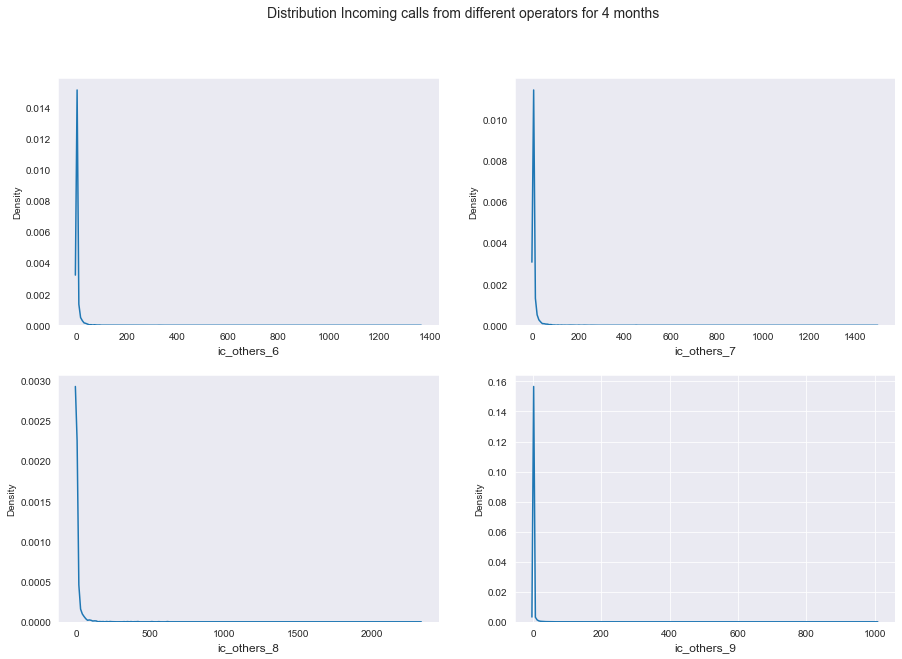

In [36]:
# Lets check the distribution on these.
# 'ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9'
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['ic_others_6'],ax=ax1)
plt.xlabel("ic_others_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['ic_others_7'],ax=ax2)
plt.xlabel("ic_others_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['ic_others_8'],ax=ax3)
plt.xlabel('ic_others_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['ic_others_9'],ax=ax4)
plt.xlabel('ic_others_9',size=12)
plt.grid()
fig.suptitle("Distribution Incoming calls from different operators for 4 months",size=14)
plt.show()

In [41]:
cols[42:50]

['isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9']

In [42]:
df[['isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
isd_ic_mou_6,99999.0,7.166881,58.553452,0.0,0.0,0.0,0.0,6789.41
isd_ic_mou_7,99999.0,8.013288,63.969156,0.0,0.0,0.0,0.0,5289.54
isd_ic_mou_8,99999.0,7.987986,62.102622,0.0,0.0,0.0,0.0,4127.01
isd_ic_mou_9,99999.0,7.438517,61.034593,0.0,0.0,0.0,0.0,5057.74
isd_og_mou_6,99999.0,0.766849,25.253433,0.0,0.0,0.0,0.0,5900.66
isd_og_mou_7,99999.0,0.746604,25.104616,0.0,0.0,0.0,0.0,5490.28
isd_og_mou_8,99999.0,0.748693,24.848715,0.0,0.0,0.0,0.0,5681.54
isd_og_mou_9,99999.0,0.667826,20.469760,0.0,0.0,0.0,0.0,4244.53


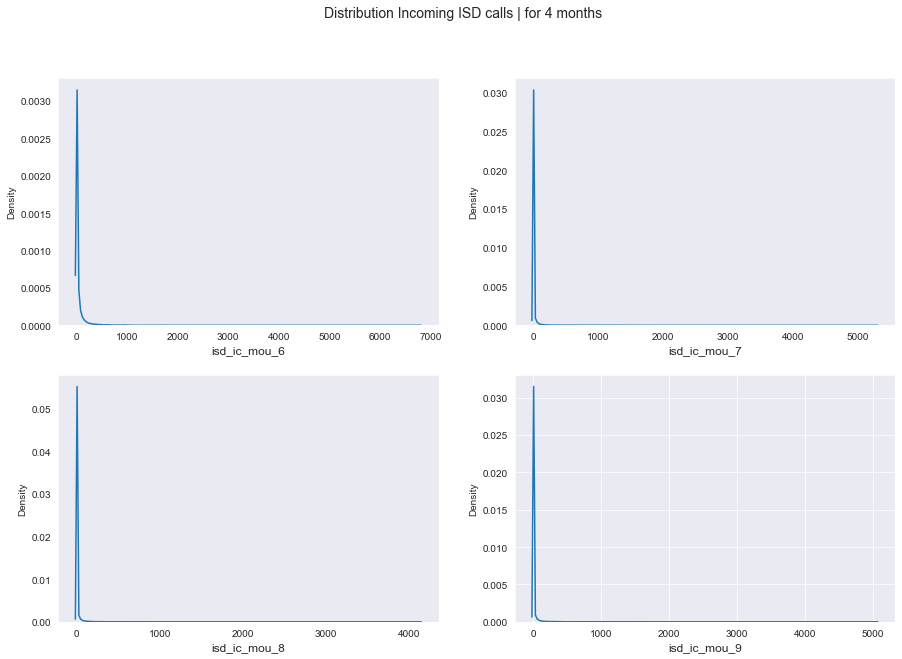

In [49]:
# Lets check the distribution on these.
# isd_ic_mou_6,7,8,9
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['isd_ic_mou_6'],ax=ax1)
plt.xlabel("isd_ic_mou_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['isd_ic_mou_7'],ax=ax2)
plt.xlabel("isd_ic_mou_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['isd_ic_mou_8'],ax=ax3)
plt.xlabel('isd_ic_mou_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['isd_ic_mou_9'],ax=ax4)
plt.xlabel('isd_ic_mou_9',size=12)
plt.grid()
fig.suptitle("Distribution Incoming ISD calls | for 4 months",size=14)
plt.show()

In [68]:
cols[50:52]

['jul_vbc_3g', 'jun_vbc_3g']

In [69]:
df[['jul_vbc_3g', 'jun_vbc_3g']].describe().T

,count,mean,std,min,25%,50%,75%,max
jul_vbc_3g,99999.0,66.839062,271.201856,0.0,0.0,0.0,0.0,9165.60
jun_vbc_3g,99999.0,60.021204,253.938223,0.0,0.0,0.0,0.0,11166.21


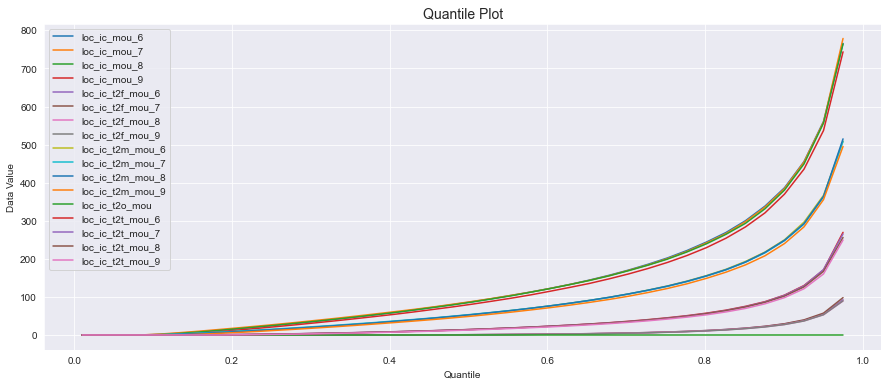

In [85]:
#It could be seen from the features that over 80 %ile of data lies below 
df[cols[57:74]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

In [95]:
df[cols[57:74]].describe().T

,count,mean,std,min,25%,50%,75%,max
loc_ic_mou_6,99999.0,160.896870,251.192138,0.0,24.68,86.04,200.58,7454.63
loc_ic_mou_7,99999.0,161.247178,253.318185,0.0,26.71,86.61,198.69,9669.91
loc_ic_mou_8,99999.0,158.427961,246.124674,0.0,24.59,84.99,197.54,10830.16
loc_ic_mou_9,99999.0,151.869401,243.975763,0.0,20.74,79.56,188.90,10796.29
loc_ic_t2f_mou_6,99999.0,11.608541,39.412899,0.0,0.00,0.68,7.53,1872.34
loc_ic_t2f_mou_7,99999.0,12.113470,42.209845,0.0,0.00,0.73,7.66,1983.01
loc_ic_t2f_mou_8,99999.0,11.119814,38.150956,0.0,0.00,0.66,7.26,2433.06
loc_ic_t2f_mou_9,99999.0,11.230289,42.234334,0.0,0.00,0.58,6.96,4318.28
loc_ic_t2m_mou_6,99999.0,103.244291,169.592626,0.0,13.81,52.36,127.60,4693.86
loc_ic_t2m_mou_7,99999.0,102.986672,167.398842,0.0,14.99,53.28,126.68,4455.83


In [90]:
# Analysis on Local Outgoing calls foreach months
cols[74:95]

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2o_mou',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9']

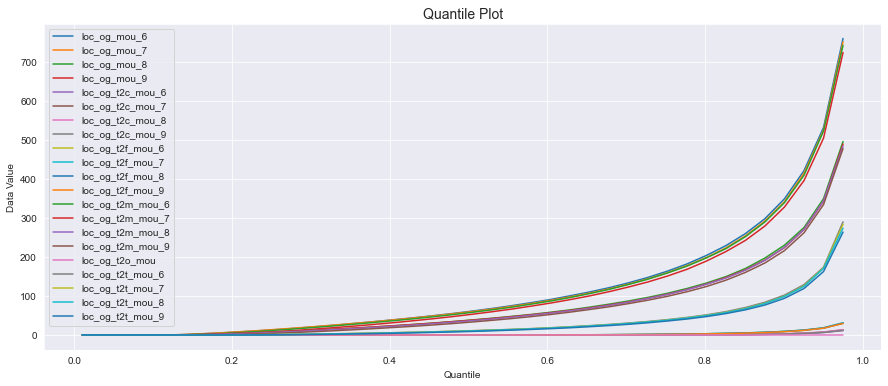

In [92]:
df[cols[74:95]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

In [94]:
df[cols[74:95]].describe().T

,count,mean,std,min,25%,50%,75%,max
loc_og_mou_6,99999.0,138.523918,248.334416,0.0,12.93,59.91,161.920,10643.38
loc_og_mou_7,99999.0,136.203358,245.406396,0.0,13.48,58.86,157.970,7674.78
loc_og_mou_8,99999.0,133.727502,241.325369,0.0,11.41,56.84,156.985,11039.91
loc_og_mou_9,99999.0,127.966775,239.110873,0.0,7.64,51.96,149.360,11099.26
loc_og_t2c_mou_6,99999.0,1.078841,5.345068,0.0,0.00,0.00,0.000,342.86
loc_og_t2c_mou_7,99999.0,1.315689,7.391356,0.0,0.00,0.00,0.000,916.24
loc_og_t2c_mou_8,99999.0,1.356709,6.606329,0.0,0.00,0.00,0.000,502.09
loc_og_t2c_mou_9,99999.0,1.137250,5.407085,0.0,0.00,0.00,0.000,339.84
loc_og_t2f_mou_6,99999.0,3.603334,13.966557,0.0,0.00,0.00,1.860,1466.03
loc_og_t2f_mou_7,99999.0,3.646613,14.006097,0.0,0.00,0.00,1.890,1196.43


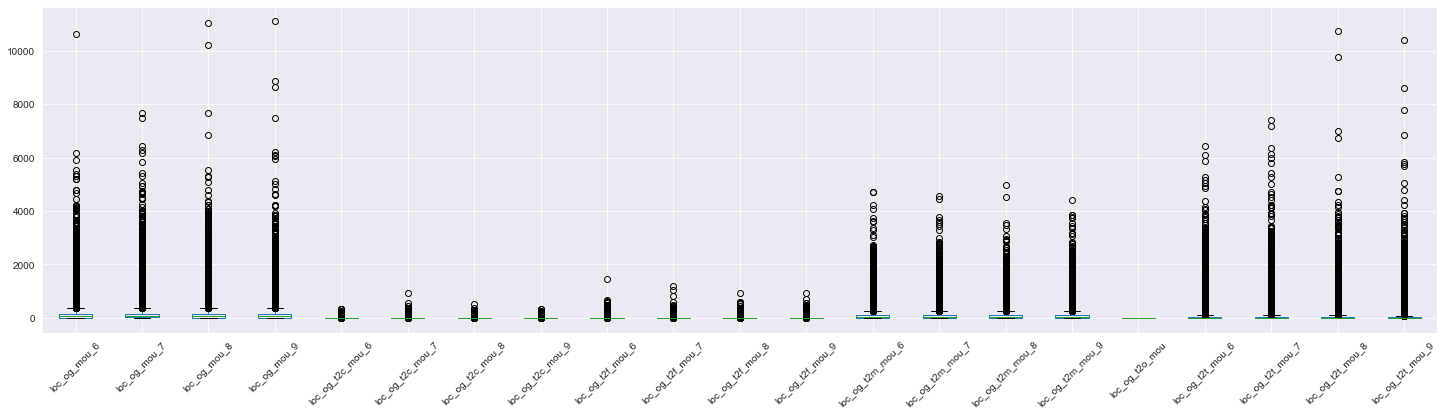

In [104]:
df[cols[74:95]].plot(kind="box",figsize=(25,6))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [110]:
cols[95:103]

['max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9']

In [111]:
df[cols[95:103]].describe().T

,count,mean,std,min,25%,50%,75%,max
max_rech_amt_6,99999.0,104.637486,120.614894,0.0,30.0,110.0,120.0,4010.0
max_rech_amt_7,99999.0,104.752398,124.523970,0.0,30.0,110.0,128.0,4010.0
max_rech_amt_8,99999.0,107.728207,126.902505,0.0,30.0,98.0,144.0,4449.0
max_rech_amt_9,99999.0,101.943889,125.375109,0.0,28.0,61.0,144.0,3399.0
max_rech_data_6,99999.0,31.792048,77.248778,0.0,0.0,0.0,8.0,1555.0
max_rech_data_7,99999.0,32.406314,78.342435,0.0,0.0,0.0,14.0,1555.0
max_rech_data_8,99999.0,33.113011,78.872739,0.0,0.0,0.0,17.0,1555.0
max_rech_data_9,99999.0,32.387644,78.818696,0.0,0.0,0.0,17.0,1555.0


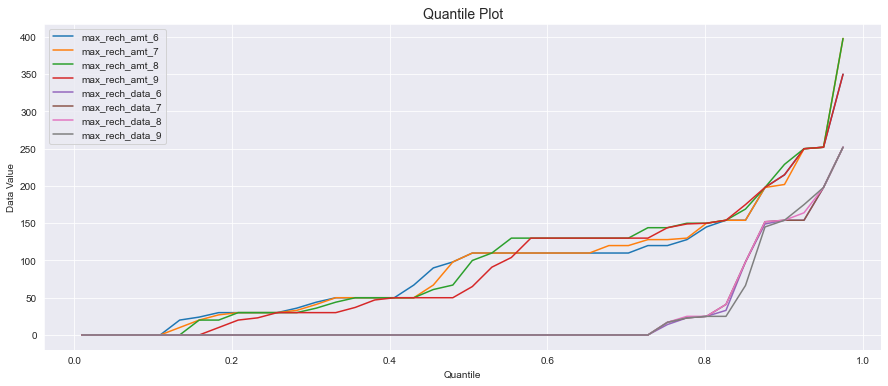

In [112]:
df[cols[95:103]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

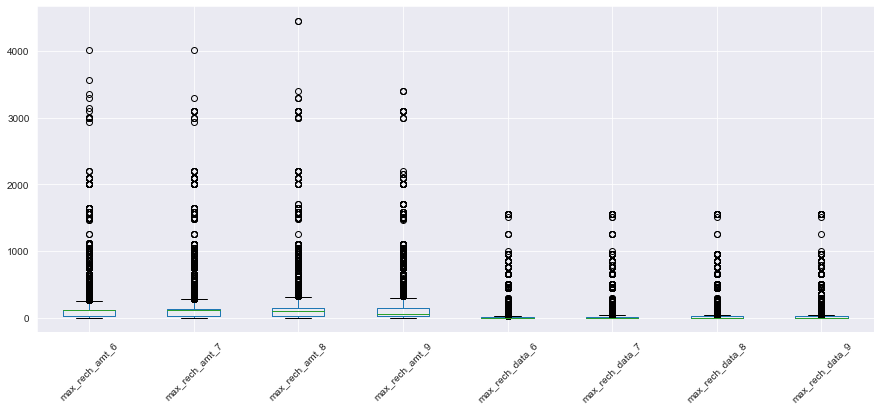

In [114]:
df[cols[95:103]].plot(kind="box",figsize=(15,6))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [118]:
# Most of the users do not use data/internet
df[cols[95:103]].quantile(np.linspace(.01, 1, 10, 0)).T

,0.010,0.109,0.208,0.307,0.406,0.505,0.604,0.703,0.802,0.901
max_rech_amt_6,0.0,0.0,30.0,44.0,50.0,110.0,110.0,110.0,145.0,215.0
max_rech_amt_7,0.0,0.0,30.0,41.0,50.0,110.0,110.0,120.0,150.0,202.0
max_rech_amt_8,0.0,0.0,30.0,36.0,50.0,100.0,130.0,130.0,150.0,229.0
max_rech_amt_9,0.0,0.0,20.0,30.0,50.0,65.0,130.0,130.0,150.0,215.0
max_rech_data_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,154.0
max_rech_data_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,154.0
max_rech_data_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,154.0
max_rech_data_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,154.0


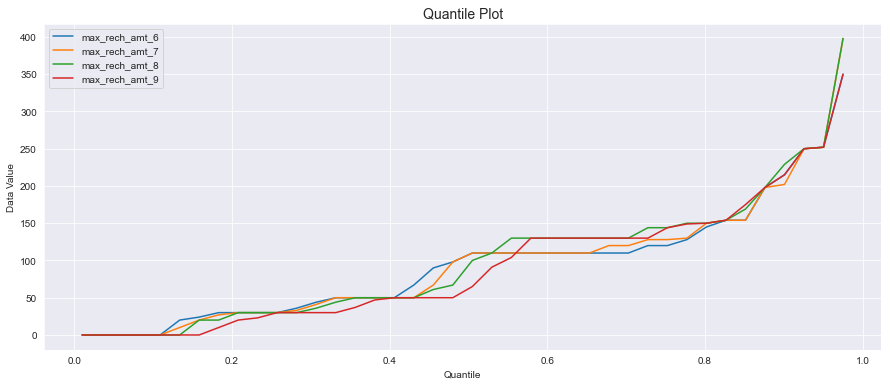

In [119]:
df[cols[95:99]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

In [7]:
cols[103:111]

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_2g_9',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'monthly_3g_9']

In [10]:
df[cols[103:111]].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_2g_6,99999.0,0.079641,0.295058,0.0,0.0,0.0,0.0,4.0
monthly_2g_7,99999.0,0.083221,0.304395,0.0,0.0,0.0,0.0,5.0
monthly_2g_8,99999.0,0.081001,0.299568,0.0,0.0,0.0,0.0,5.0
monthly_2g_9,99999.0,0.068781,0.278120,0.0,0.0,0.0,0.0,4.0
monthly_3g_6,99999.0,0.075921,0.363371,0.0,0.0,0.0,0.0,14.0
monthly_3g_7,99999.0,0.078581,0.387231,0.0,0.0,0.0,0.0,16.0
monthly_3g_8,99999.0,0.082941,0.384947,0.0,0.0,0.0,0.0,16.0
monthly_3g_9,99999.0,0.086341,0.384978,0.0,0.0,0.0,0.0,11.0


C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='monthly_2g_6', ylabel='count'>

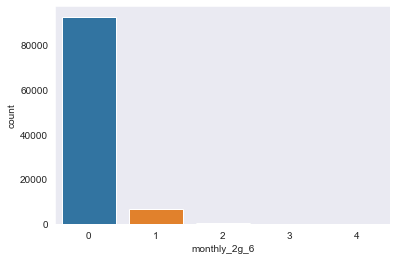

In [17]:
sns.countplot(df['monthly_2g_6'])

In [21]:
# These are categorical column
print("Printing Unique values in each features: ")
print("=="*50)
for i in cols[103:111]:
    print(i, df[i].unique())
    print("=="*50)

Printing Unique values in each features: 
monthly_2g_6 [0 1 2 3 4]
monthly_2g_7 [0 1 2 5 4 3]
monthly_2g_8 [0 1 2 5 3 4]
monthly_2g_9 [0 2 1 3 4]
monthly_3g_6 [ 1  0  4  2  3  5  7  6  9  8 11 14]
monthly_3g_7 [ 1  0  2  5  3  8  4  7  6  9 11 12 14 10 16]
monthly_3g_8 [ 1  0  2  7  3  4  6  5  8 10  9 16]
monthly_3g_9 [ 0  1  2  8  3  4  5  6  7 11  9]


In [28]:
# This is also a categorical variable
df[cols[111:115]].describe().T

,count,mean,std,min,25%,50%,75%,max
night_pck_user_6,99999.0,0.00631,0.079185,0.0,0.0,0.0,0.0,1.0
night_pck_user_7,99999.0,0.00589,0.076521,0.0,0.0,0.0,0.0,1.0
night_pck_user_8,99999.0,0.00549,0.073892,0.0,0.0,0.0,0.0,1.0
night_pck_user_9,99999.0,0.00414,0.064210,0.0,0.0,0.0,0.0,1.0


In [5]:
cols[115:119]

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']

In [6]:
# Other Network Minuite calls
df[cols[115:119]].describe().T

,count,mean,std,min,25%,50%,75%,max
offnet_mou_6,99999.0,190.142776,312.928229,0.0,28.76,89.68,222.535,8362.36
offnet_mou_7,99999.0,189.441086,321.759659,0.0,26.65,85.44,217.830,9667.13
offnet_mou_8,99999.0,186.002904,321.325854,0.0,23.84,83.13,215.500,14007.34
offnet_mou_9,99999.0,175.595457,310.968398,0.0,16.03,74.68,202.830,10310.76


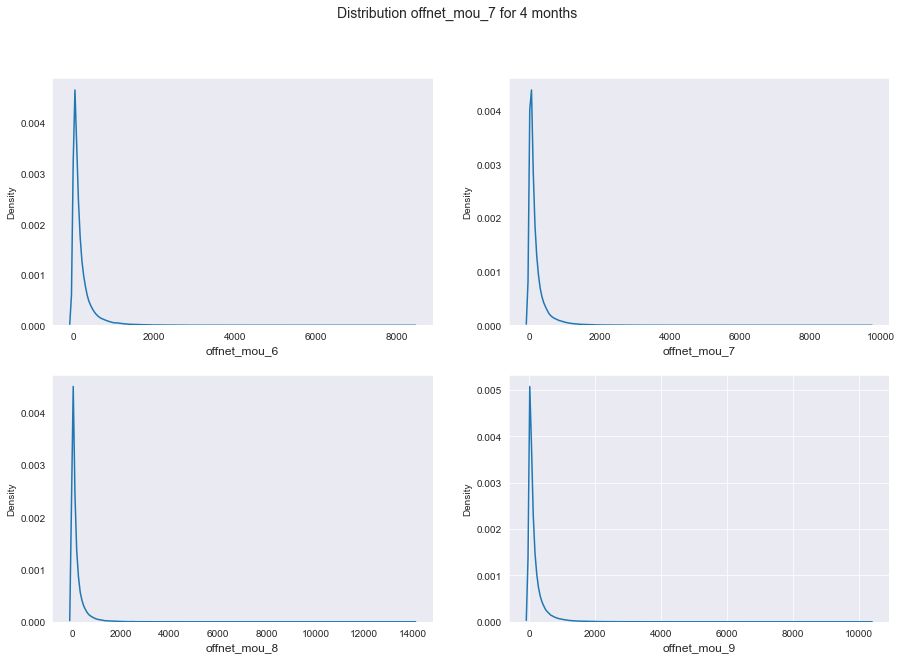

In [17]:
# This is again highly skeved distribution
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['offnet_mou_6'],ax=ax1)
plt.xlabel("offnet_mou_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(df['offnet_mou_7'],ax=ax2)
plt.xlabel("offnet_mou_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(df['offnet_mou_8'],ax=ax3)
plt.xlabel('offnet_mou_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(df['offnet_mou_9'],ax=ax4)
plt.xlabel('offnet_mou_9',size=12)
plt.grid()
fig.suptitle("Distribution offnet_mou_7 for 4 months",size=14)
plt.show()

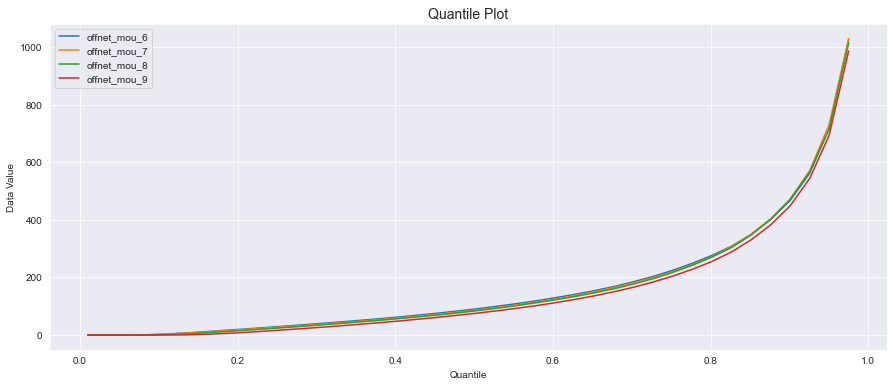

In [18]:
df[cols[115:119]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

In [20]:
cols[119:123]

['og_others_6', 'og_others_7', 'og_others_8', 'og_others_9']

In [21]:
# This also seems to be a highly skeved feature
# Outgoing others
df[cols[119:123]].describe().T

,count,mean,std,min,25%,50%,75%,max
og_others_6,99999.0,0.436277,4.044839,0.0,0.0,0.0,0.0,800.89
og_others_7,99999.0,0.029069,2.119603,0.0,0.0,0.0,0.0,370.13
og_others_8,99999.0,0.031577,2.260134,0.0,0.0,0.0,0.0,394.93
og_others_9,99999.0,0.043780,3.491866,0.0,0.0,0.0,0.0,787.79


In [23]:
cols[123:127]

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9']

In [24]:
# Same network voice
df[cols[123:127]].describe().T

,count,mean,std,min,25%,50%,75%,max
onnet_mou_6,99999.0,127.183397,292.433718,0.0,5.43,30.98,112.61,7376.71
onnet_mou_7,99999.0,128.512397,303.869995,0.0,4.88,29.23,108.88,8157.78
onnet_mou_8,99999.0,125.864313,302.023240,0.0,4.09,28.04,106.74,10752.56
onnet_mou_9,99999.0,120.210311,298.331154,0.0,2.19,23.84,99.09,10427.46


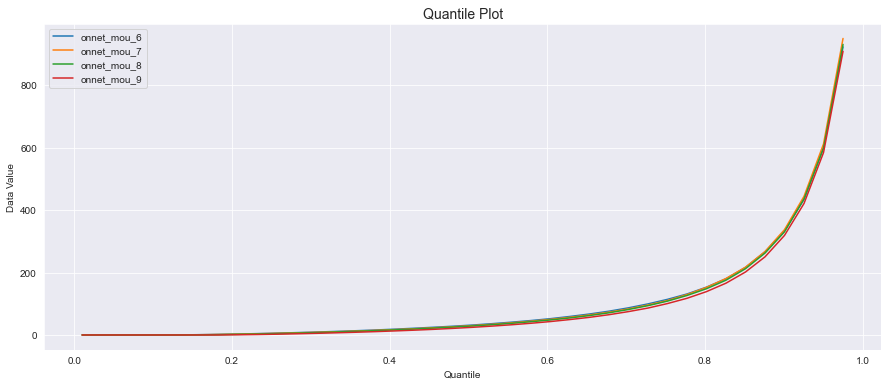

In [25]:
df[cols[123:127]].quantile(np.linspace(.01, 1, 40, 0)).plot(figsize=(15,6))
plt.grid()
plt.xlabel("Quantile")
plt.ylabel("Data Value")
plt.title("Quantile Plot",size = 14)
plt.show()

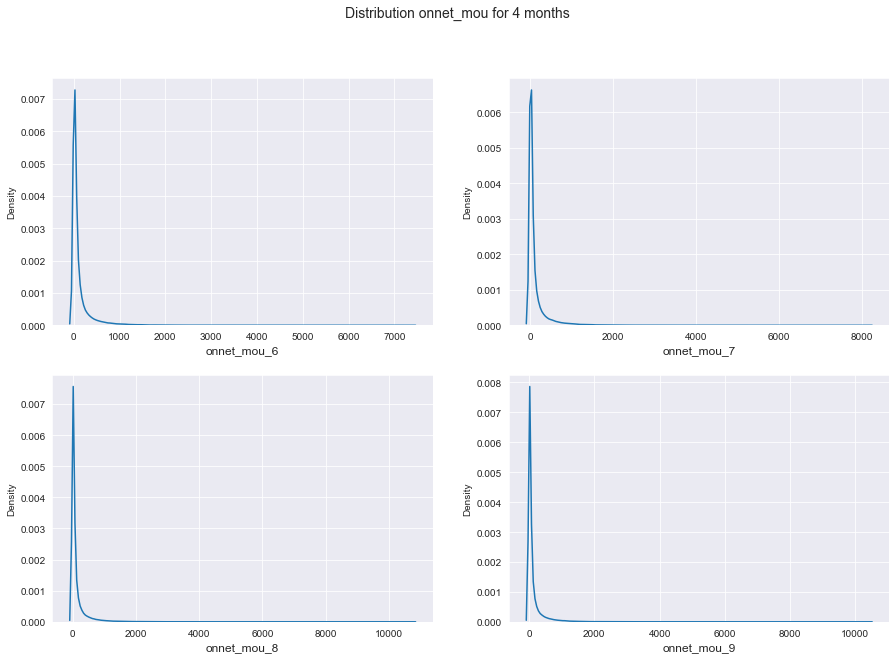

In [30]:
# This is again highly skeved distribution
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(df['onnet_mou_6'],ax=ax1)
plt.xlabel("onnet_mou_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.kdeplot(df['onnet_mou_7'],ax=ax2)
plt.xlabel("onnet_mou_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.kdeplot(df['onnet_mou_8'],ax=ax3)
plt.xlabel('onnet_mou_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(df['onnet_mou_9'],ax=ax4)
plt.xlabel('onnet_mou_9',size=12)
plt.grid()
fig.suptitle("Distribution onnet_mou for 4 months",size=14)
plt.show()

In [34]:
cols[127:135]

['roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9']

In [36]:
# These are also a highly skewed features
df[cols[127:135]].describe().T

,count,mean,std,min,25%,50%,75%,max
roam_ic_mou_6,99999.0,9.558277,71.403643,0.0,0.0,0.0,0.0,13724.38
roam_ic_mou_7,99999.0,6.873981,72.029965,0.0,0.0,0.0,0.0,15371.04
roam_ic_mou_8,99999.0,6.900761,66.558003,0.0,0.0,0.0,0.0,13095.36
roam_ic_mou_9,99999.0,5.852505,54.906445,0.0,0.0,0.0,0.0,8464.03
roam_og_mou_6,99999.0,13.363643,70.074931,0.0,0.0,0.0,0.0,3775.11
roam_og_mou_7,99999.0,9.439823,57.347933,0.0,0.0,0.0,0.0,2812.04
roam_og_mou_8,99999.0,9.435597,62.989180,0.0,0.0,0.0,0.0,5337.04
roam_og_mou_9,99999.0,7.892887,56.176090,0.0,0.0,0.0,0.0,4428.46


#### Filter high-value customers <br>

As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [5]:
df.fillna(value=0,inplace=True)

In [9]:
df[cols[14:16]].quantile(np.linspace(.7, 1, 20, 0))

,av_rech_amt_data_6,av_rech_amt_data_7
0.700,0.00,0.0
0.715,0.00,0.0
0.730,0.00,0.0
0.745,0.00,7.0
0.760,17.00,25.0
0.775,25.00,41.0
0.790,49.00,51.0
0.805,69.00,91.0
0.820,98.00,100.0
0.835,125.00,145.0


In [10]:
df[cols[201:213]].quantile(np.linspace(.7, 1, 20, 0))#.plot(figsize=(15,6))
#plt.grid()
#plt.show()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9
0.700,378.0,370.0,380.00,355.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0
0.715,396.0,386.0,394.00,376.0,0.0,0.0,0.0,0.0,9.0,9.0,8.0,8.0
0.730,410.0,402.0,410.00,390.0,0.0,0.0,0.0,0.0,9.0,9.0,9.0,8.0
0.745,430.0,421.0,428.00,409.0,0.0,1.0,1.0,1.0,9.0,9.0,9.0,9.0
0.760,450.0,440.0,448.00,427.0,1.0,1.0,1.0,1.0,10.0,10.0,9.0,9.0
0.775,470.0,460.0,466.00,449.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,10.0
0.790,492.0,484.0,492.00,469.0,1.0,1.0,1.0,1.0,10.0,11.0,10.0,10.0
0.805,510.0,504.0,511.00,496.0,1.0,1.0,1.0,1.0,11.0,11.0,11.0,10.0
0.820,537.0,529.0,537.00,519.0,1.0,1.0,1.0,1.0,11.0,12.0,11.0,11.0
0.835,562.0,556.0,564.00,546.0,1.0,1.0,1.0,1.0,12.0,12.0,12.0,11.0


In [49]:
df[(df.total_rech_num_6>0)&(df.total_rech_amt_6==0)][['total_rech_amt_6','total_rech_num_6']]

,total_rech_amt_6,total_rech_num_6
10,0,1
15,0,1
18,0,1
23,0,3
30,0,3
...,...,...
99933,0,1
99964,0,2
99972,0,1
99978,0,1


In [27]:
# Finding Average Recharge for all users for all 4 months
df['avg_rech_6'] = df['total_rech_amt_6']/df['total_rech_num_6']
df['avg_rech_7'] = df['total_rech_amt_7']/df['total_rech_num_7']
df['avg_rech_8'] = df['total_rech_amt_8']/df['total_rech_num_8']
df['avg_rech_9'] = df['total_rech_amt_9']/df['total_rech_num_9']

In [48]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
df['total_data_rech_6'] = df.total_rech_data_6 * df.av_rech_amt_data_6
df['total_data_rech_7'] = df.total_rech_data_7 * df.av_rech_amt_data_7

# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
df['amt_data_6'] = df.total_rech_amt_6 + df.total_data_rech_6
df['amt_data_7'] = df.total_rech_amt_7 + df.total_data_rech_7

df['av_amt_data_6_7'] = (df.amt_data_6 + df.amt_data_7)/2

print("Recharge amount at 70th percentile: {0}".format(df.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 478.0


In [49]:
# retain only those customers who have recharged their mobiles with more than or equal to 70th percentile amount
data_high_cust = df.loc[df.av_amt_data_6_7 >= df.av_amt_data_6_7.quantile(0.7), :]
data_high_cust = data_high_cust.reset_index(drop=True)
data_high_cust.shape

(30001, 233)

In [50]:
# delete variables created to filter high-value customers
data_high_cust = data_high_cust.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7',
                                     'avg_rech_6','avg_rech_7','avg_rech_8','avg_rech_9'], axis=1)
data_high_cust.shape

(30001, 224)

In [52]:
data_high_cust.to_pickle('data_high_cust.pkl')

In [2]:
data_high_cust = pd.read_pickle('data_high_cust.pkl')

In [53]:
# Lets check the missing values in the dataframe
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing_Values', 1 : 'Per_of_Total_Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    'Per_of_Total_Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_value = missing_values_table(data_high_cust)
missing_value

Your selected dataframe has 224 columns.
There are 0 columns that have missing values.


,Missing_Values,Per_of_Total_Values


In [7]:
# These above two features are created, and hence would be dropped
data_high_cust.drop(['avg_rech_6','avg_rech_7','avg_rech_8','avg_rech_9'],axis=1,inplace=True)

In [8]:
cols = list(data_high_cust)
cols.sort()

In [9]:
cols

['aon',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'aug_vbc_3g',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'ic_others_9',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'last_date_of_month_6',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',


# EDA on the new data

In [2]:
data_high_cust = pd.read_pickle('data_high_cust.pkl')
# These above two features are created, and hence would be dropped
#data_high_cust.drop(['avg_rech_6','avg_rech_7','avg_rech_8','avg_rech_9'],axis=1,inplace=True)
cols = list(data_high_cust)
cols.sort()

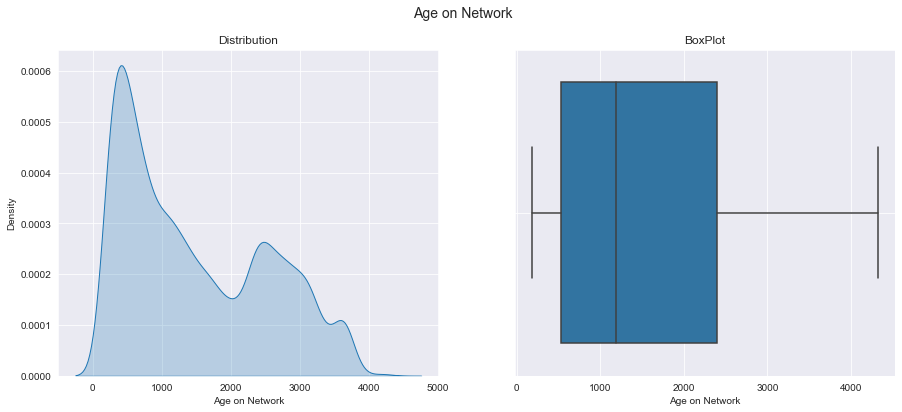

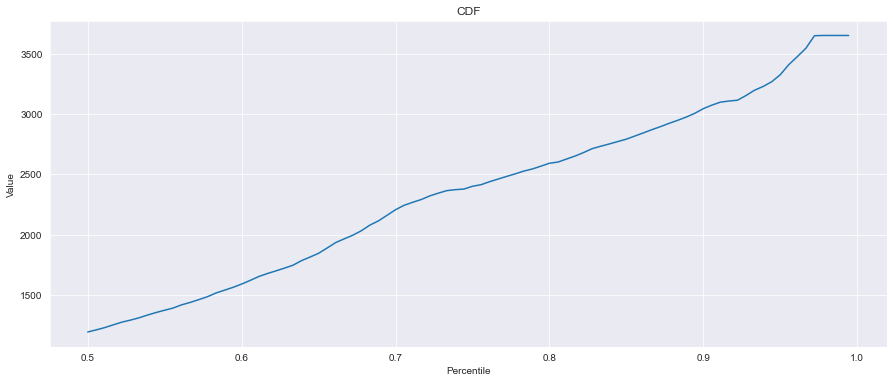

In [34]:
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
sns.kdeplot(data_high_cust['aon'],ax = ax1,shade=True)
plt.xlabel("Age on Network")
plt.title("Distribution")
plt.grid()
ax2 = plt.subplot(122)
sns.boxplot(data = data_high_cust,x = 'aon',ax=ax2)
plt.title("BoxPlot")
plt.xlabel("Age on Network")
plt.grid()
fig.suptitle("Age on Network",size=14)
plt.show()
data_high_cust['aon'].quantile(np.linspace(0.5, 1, 90, 0)).plot(figsize=(15,6))
plt.xlabel("Percentile")
plt.ylabel("Value")
plt.title("CDF")
plt.grid()

In [5]:
# Seems like there has been some investment been made from the Company end in order to retain these customers
data_high_cust[['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].describe().T

,count,mean,std,min,25%,50%,75%,max
arpu_2g_6,30001.0,63.439374,161.008235,-15.32,0.0,0.0,50.67,6433.76
arpu_2g_7,30001.0,64.701428,165.284232,-15.48,0.0,0.0,47.22,4809.36
arpu_2g_8,30001.0,58.395301,152.625125,-24.43,0.0,0.0,26.90,3467.17
arpu_2g_9,30001.0,61.573465,155.970372,-45.74,0.0,0.0,35.30,3467.17
arpu_3g_6,30001.0,67.007633,179.161038,-30.28,0.0,0.0,35.00,6362.28
arpu_3g_7,30001.0,68.621327,183.133851,-26.04,0.0,0.0,35.69,4980.90
arpu_3g_8,30001.0,62.773480,170.173104,-24.49,0.0,0.0,20.92,3716.90
arpu_3g_9,30001.0,67.752417,197.239982,-71.09,0.0,0.0,21.91,13884.31


In [39]:
data_high_cust[['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9']].quantile(np.linspace(.1, 1, 9, 0))

,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9
0.1,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.2,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.3,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.4,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.5,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.6,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.7,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000
0.8,63.96,63.96,35.71,63.92,59.790,63.96,39.11,61.000
0.9,212.17,212.17,212.17,212.17,215.845,218.14,214.64,217.715


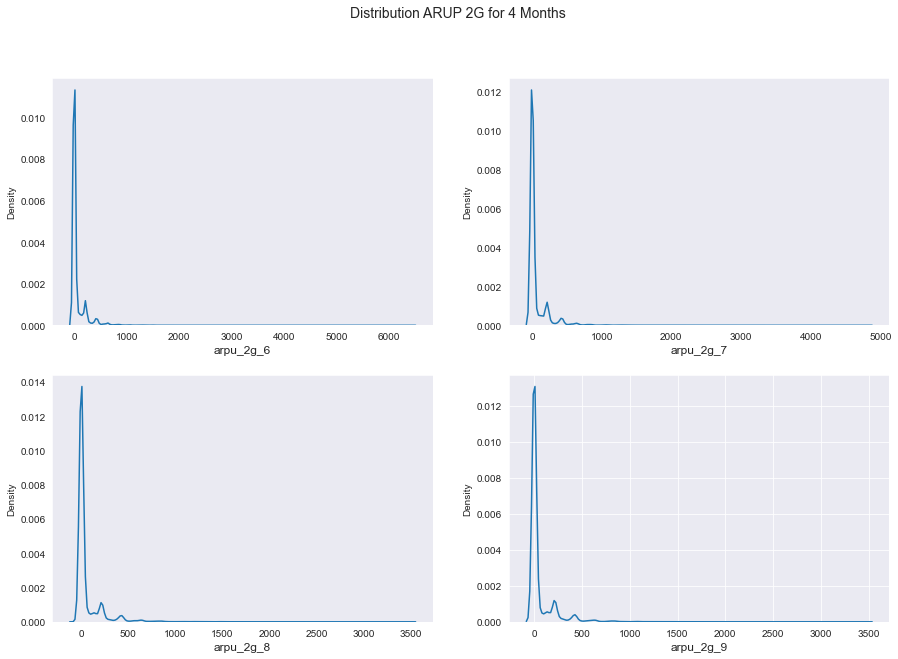

In [41]:
# Lets check the distribution on these.
# arpu_2g (Average revenue per user) for each months, looks like most of the users do not use 2G data
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
ax1 = plt.subplot(221)
sns.kdeplot(data_high_cust['arpu_2g_6'],ax=ax1)
plt.xlabel("arpu_2g_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(data_high_cust['arpu_2g_7'],ax=ax2)
plt.xlabel("arpu_2g_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(data_high_cust['arpu_2g_8'],ax=ax3)
plt.xlabel('arpu_2g_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(data_high_cust['arpu_2g_9'],ax=ax4)
plt.xlabel('arpu_2g_9',size=12)
plt.grid()
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
plt.show()

In [5]:
cols[9:]

['arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'aug_vbc_3g',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'ic_others_9',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_ic_mou_9',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'isd_og_mou_9',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'last_date_of_month_6',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'last_day_rch_amt_9',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_mou_9',
 'loc_

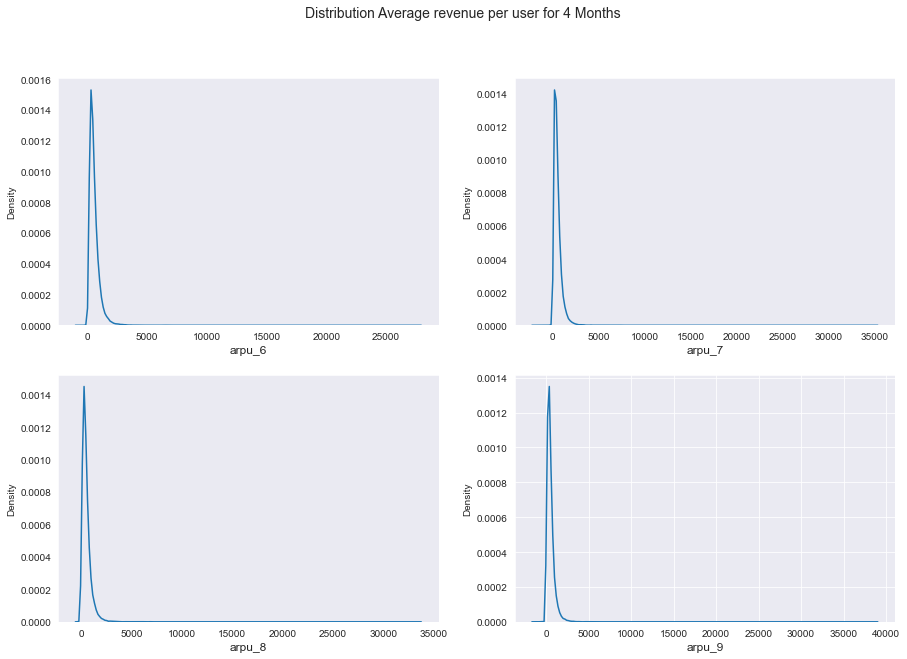

In [9]:
# Average revenue per user
# Lets check the distribution on these.
# arpu for each months
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(data_high_cust['arpu_6'],ax=ax1)
plt.xlabel("arpu_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(data_high_cust['arpu_7'],ax=ax2)
plt.xlabel("arpu_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(data_high_cust['arpu_8'],ax=ax3)
plt.xlabel('arpu_8',size=12)
ax4 = plt.subplot(224)
sns.kdeplot(data_high_cust['arpu_9'],ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
fig.suptitle("Distribution Average revenue per user for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
 

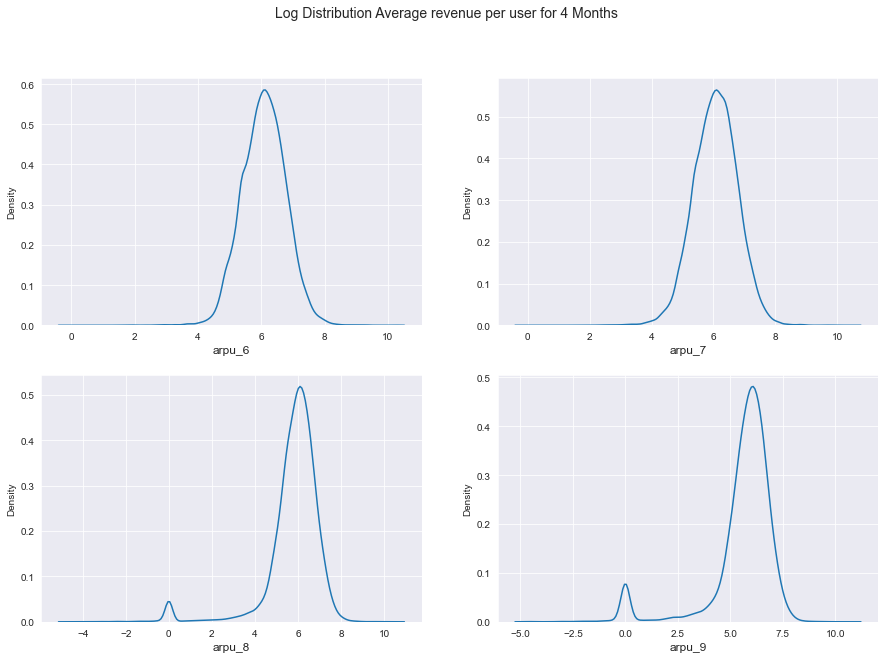

In [24]:
# Average revenue per user
# Lets check the distribution on these.
# Here it shows a much more normal like distribution
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.kdeplot(np.log(data_high_cust['arpu_6']),ax=ax1)
plt.xlabel("arpu_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.kdeplot(np.log(data_high_cust['arpu_7']),ax=ax2)
plt.xlabel("arpu_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.kdeplot(np.log(data_high_cust['arpu_8']).replace([np.inf, -np.inf],0),ax=ax3)
plt.xlabel('arpu_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(np.log(data_high_cust['arpu_9']).replace([np.inf, -np.inf],0),ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
fig.suptitle("Log Distribution Average revenue per user for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-

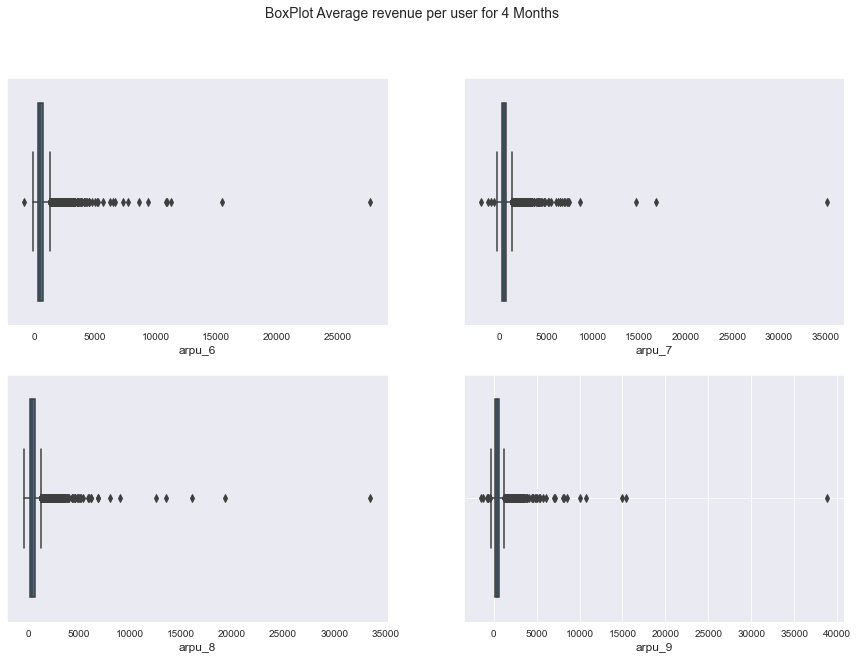

In [39]:
# Average revenue per user
# Lets check the distribution on these.
# arpu for each months
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.boxplot(data_high_cust['arpu_6'],ax=ax1)
plt.xlabel("arpu_6",size=12)
ax2 = plt.subplot(222)
sns.boxplot(data_high_cust['arpu_7'],ax=ax2)
plt.xlabel("arpu_7",size=12)
ax3 = plt.subplot(223)
sns.boxplot(data_high_cust['arpu_8'],ax=ax3)
plt.xlabel('arpu_8',size=12)
ax4 = plt.subplot(224)
sns.boxplot(data_high_cust['arpu_9'],ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
fig.suptitle("BoxPlot Average revenue per user for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Use

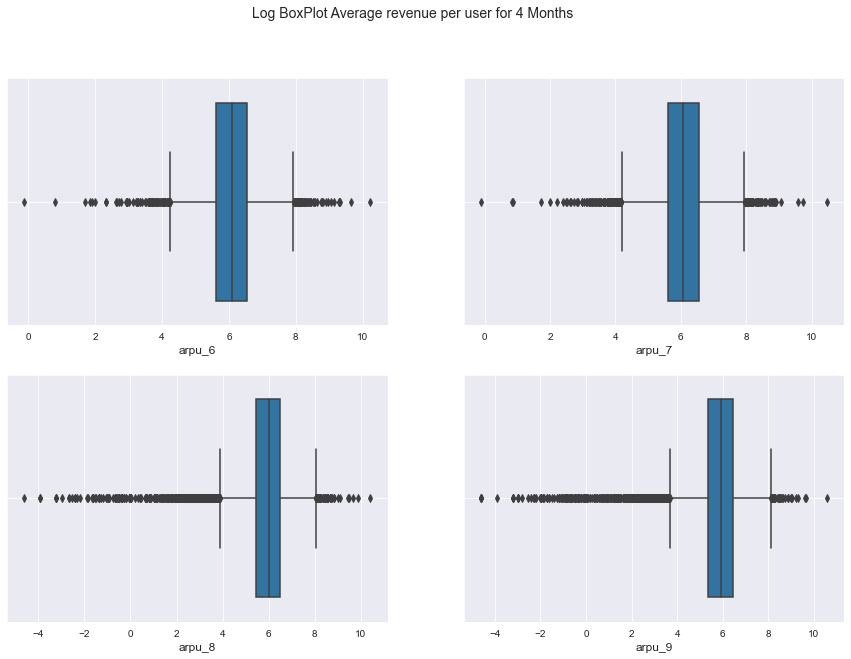

In [40]:
# Average revenue per user
# Lets check the distribution on these.
# Here it shows a much more normal like distribution
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
sns.boxplot(np.log(data_high_cust['arpu_6']),ax=ax1)
plt.xlabel("arpu_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.boxplot(np.log(data_high_cust['arpu_7']),ax=ax2)
plt.xlabel("arpu_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.boxplot(np.log(data_high_cust['arpu_8']).replace([np.inf, -np.inf],0),ax=ax3)
plt.xlabel('arpu_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.boxplot(np.log(data_high_cust['arpu_9']).replace([np.inf, -np.inf],0),ax=ax4)
plt.xlabel('arpu_9',size=12)
plt.grid()
fig.suptitle("Log BoxPlot Average revenue per user for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


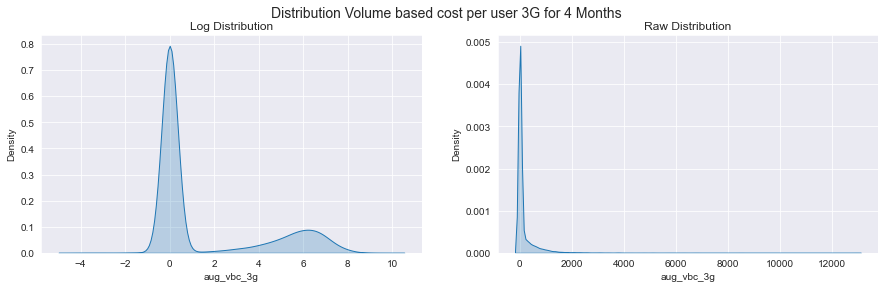

In [37]:
# Volume based cost - when no specific scheme is not purchased and paid as per usage
# Taking 
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
sns.kdeplot(np.log(data_high_cust['aug_vbc_3g']).replace([-np.inf,np.inf],0),shade=True,ax = ax1)
plt.title("Log Distribution")
plt.grid()
ax2 = plt.subplot(122)
sns.kdeplot(data_high_cust['aug_vbc_3g'],shade=True,ax = ax2)
plt.grid()
plt.title("Raw Distribution")
fig.suptitle("Distribution Volume based cost per user 3G for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


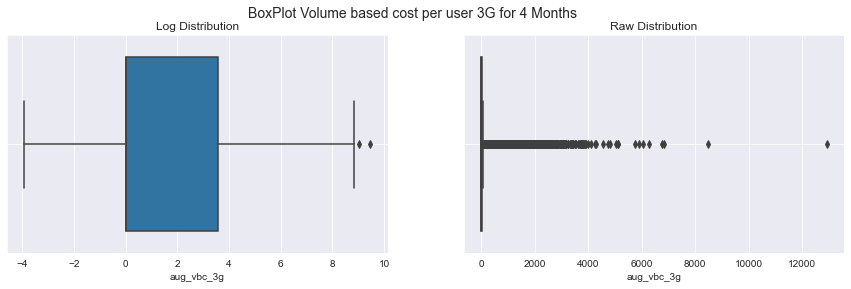

In [42]:
# Volume based cost - when no specific scheme is not purchased and paid as per usage
# Taking 
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
sns.boxplot(np.log(data_high_cust['aug_vbc_3g']).replace([-np.inf,np.inf],0),ax = ax1,hue='churn')
plt.title("Log Distribution")
plt.grid()
ax2 = plt.subplot(122)
sns.boxplot(data_high_cust['aug_vbc_3g'],ax = ax2)
plt.grid()
plt.title("Raw Distribution")
fig.suptitle("BoxPlot Volume based cost per user 3G for 4 Months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


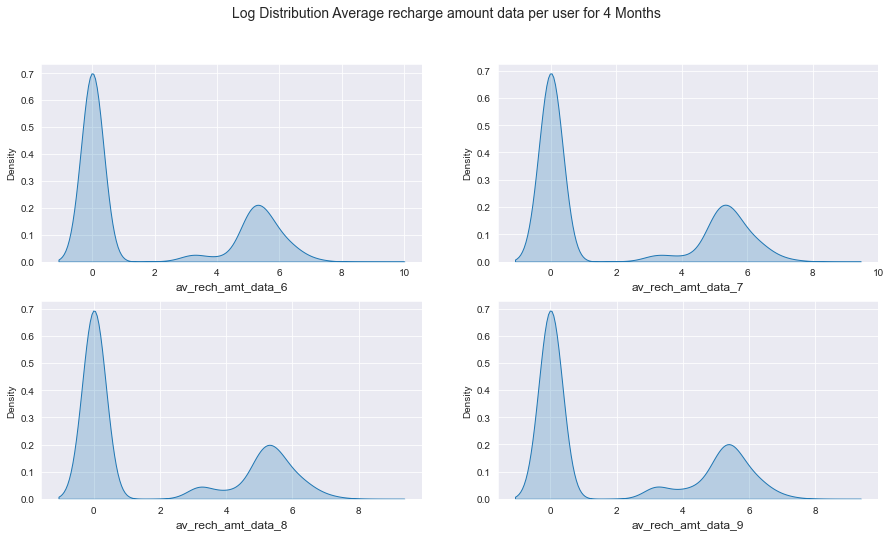

In [47]:
# Average recharge amount data
# Lets check the distribution on these.
# Here it shows a much more normal like distribution
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221)
sns.kdeplot(np.log(data_high_cust['av_rech_amt_data_6']).replace([np.inf, -np.inf],0),ax=ax1,shade=True)
plt.xlabel("av_rech_amt_data_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.kdeplot(np.log(data_high_cust['av_rech_amt_data_7']).replace([np.inf, -np.inf],0),ax=ax2,shade=True)
plt.xlabel("av_rech_amt_data_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.kdeplot(np.log(data_high_cust['av_rech_amt_data_8']).replace([np.inf, -np.inf],0),ax=ax3,shade=True)
plt.xlabel('av_rech_amt_data_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(np.log(data_high_cust['av_rech_amt_data_9']).replace([np.inf, -np.inf],0),ax=ax4,shade = True)
plt.xlabel('av_rech_amt_data_9',size=12)
plt.grid()
fig.suptitle("Log Distribution Average recharge amount data per user for 4 Months",size=14)
plt.show()

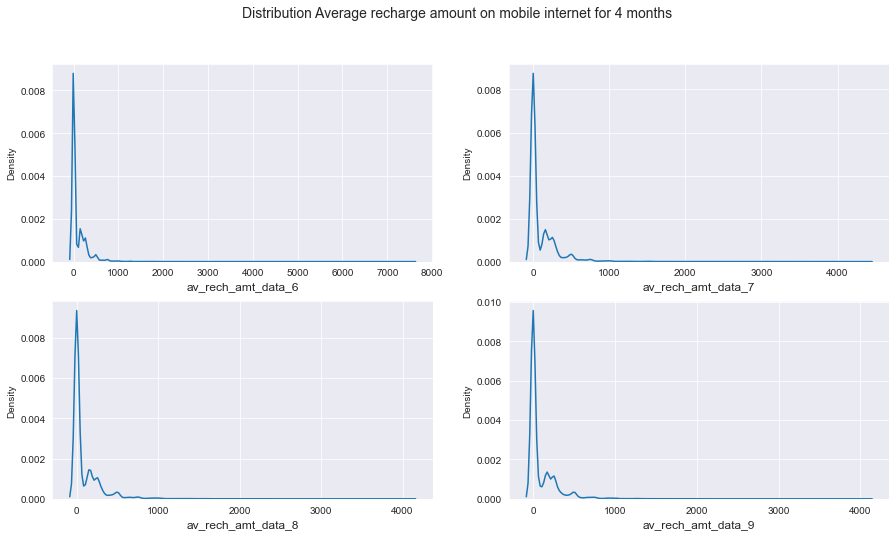

In [50]:
# Lets check the distribution on these.
# arpu for each months
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221)
sns.kdeplot(data_high_cust['av_rech_amt_data_6'],ax=ax1)
plt.grid()
plt.xlabel("av_rech_amt_data_6",size=12)
ax2 = plt.subplot(222)
sns.kdeplot(data_high_cust['av_rech_amt_data_7'],ax=ax2)
plt.grid()
plt.xlabel("av_rech_amt_data_7",size=12)
ax3 = plt.subplot(223)
sns.kdeplot(data_high_cust['av_rech_amt_data_8'],ax=ax3)
plt.xlabel('av_rech_amt_data_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(data_high_cust['av_rech_amt_data_9'],ax=ax4)
plt.xlabel('av_rech_amt_data_9',size=12)
plt.grid()
fig.suptitle("Distribution Average recharge amount on mobile internet for 4 months",size=14)
plt.show()

C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lette\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


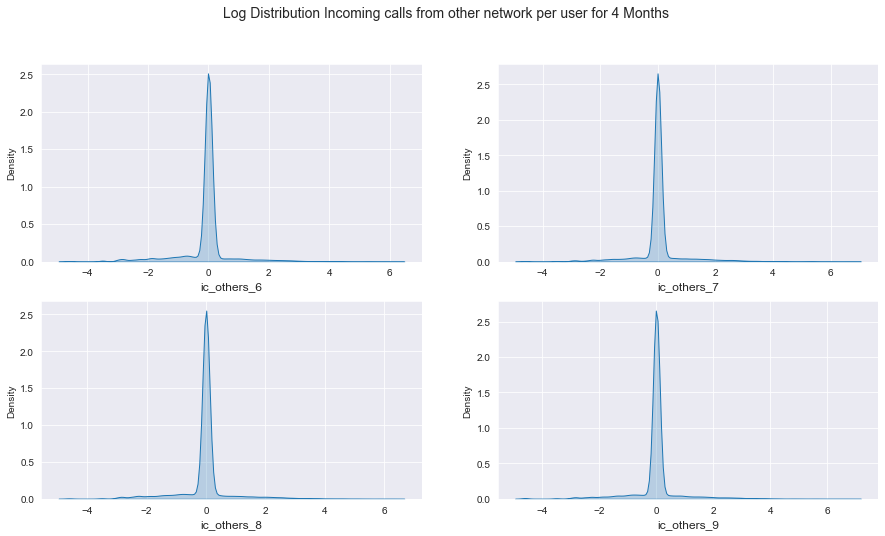

In [24]:
#cols[38:42]

# Average recharge amount data
# Lets check the distribution on these.
# Here it shows a much more normal like distribution
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221)
sns.kdeplot(np.log(data_high_cust['ic_others_6']).replace([np.inf, -np.inf],0),ax=ax1,shade=True)
plt.xlabel("ic_others_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.kdeplot(np.log(data_high_cust['ic_others_7']).replace([np.inf, -np.inf],0),ax=ax2,shade=True)
plt.xlabel("ic_others_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.kdeplot(np.log(data_high_cust['ic_others_8']).replace([np.inf, -np.inf],0),ax=ax3,shade=True)
plt.xlabel('ic_others_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(np.log(data_high_cust['ic_others_9']).replace([np.inf, -np.inf],0),ax=ax4,shade = True)
plt.xlabel('ic_others_9',size=12)
plt.grid()
fig.suptitle("Log Distribution Incoming calls from other network per user for 4 Months",size=14)
plt.show()

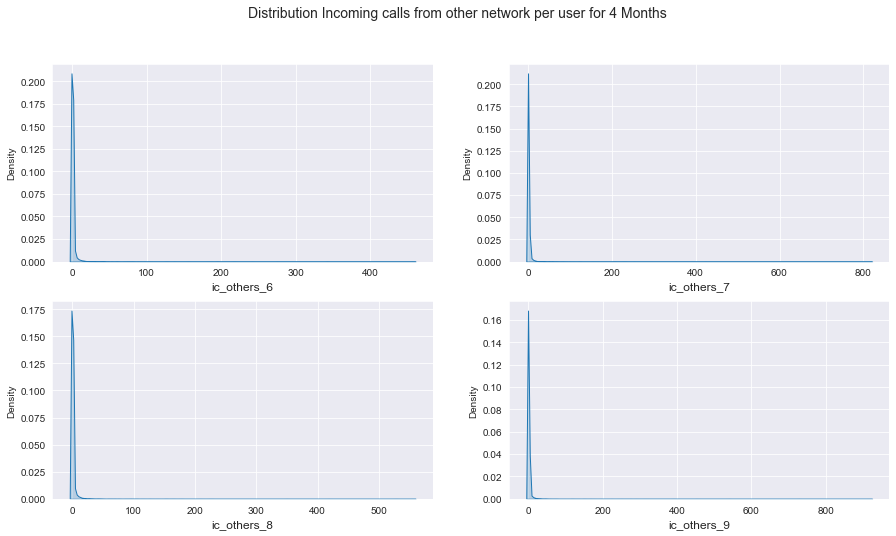

In [26]:
#

# Average recharge amount data
# Lets check the distribution on these.
# Here it shows a much more normal like distribution
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221)
sns.kdeplot(data_high_cust['ic_others_6'],ax=ax1,shade=True)
plt.xlabel("ic_others_6",size=12)
plt.grid()
ax2 = plt.subplot(222)
sns.kdeplot(data_high_cust['ic_others_7'],ax=ax2,shade=True)
plt.xlabel("ic_others_7",size=12)
plt.grid()
ax3 = plt.subplot(223)
sns.kdeplot(data_high_cust['ic_others_8'],ax=ax3,shade=True)
plt.xlabel('ic_others_8',size=12)
plt.grid()
ax4 = plt.subplot(224)
sns.kdeplot(data_high_cust['ic_others_9'],ax=ax4,shade = True)
plt.xlabel('ic_others_9',size=12)
plt.grid()
fig.suptitle("Distribution Incoming calls from other network per user for 4 Months",size=14)
plt.show()

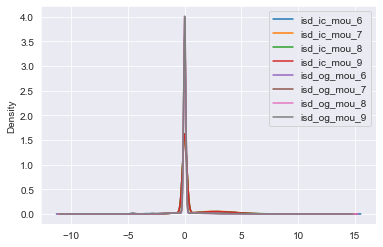

In [36]:
np.log(data_high_cust[cols[42:50]]).replace([np.inf, -np.inf],0).plot(kind='kde')
plt.grid()
plt.show()

## Deriving Churn

In [55]:
# calculate total incoming and outgoing minutes of usage
data_high_cust['total_calls_mou_9'] = data_high_cust.total_ic_mou_9 + data_high_cust.total_og_mou_9

# calculate 2g and 3g data consumption
data_high_cust['total_internet_mb_9'] =  data_high_cust.vol_2g_mb_9 + data_high_cust.vol_3g_mb_9

# create churn variable: those who have not used either calls or internet in the month of September are customers who have churned

# 0 - not churn, 1 - churn
data_high_cust['churn'] = data_high_cust.apply(lambda row: 1 if (row.total_calls_mou_9 == 0 and row.total_internet_mb_9 == 0) else 0, axis=1)

# delete derived variables
data_high_cust = data_high_cust.drop(['total_calls_mou_9', 'total_internet_mb_9'], axis=1)

# change data type to category
data_high_cust.churn = data_high_cust.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(data_high_cust.churn.value_counts()*100/data_high_cust.shape[0])

Churn Ratio:
0    91.863605
1     8.136395
Name: churn, dtype: float64


In [56]:
data_high_cust.to_pickle("data_with_churn.pkl")

## Lets check how the dependent variable is getting affected by the independent features

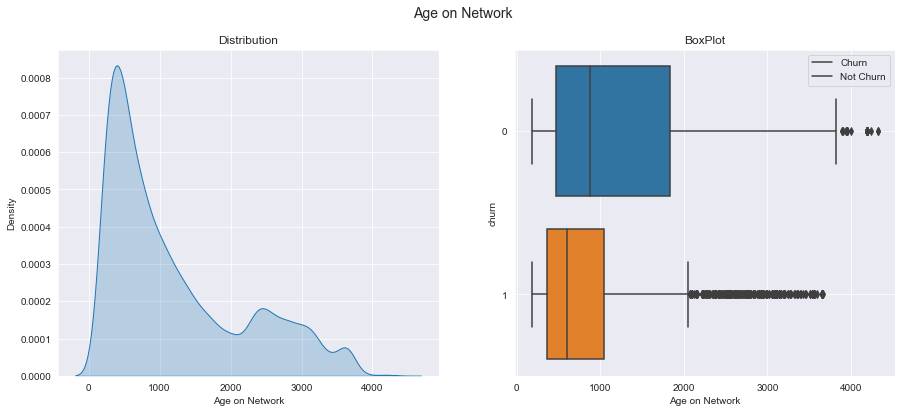

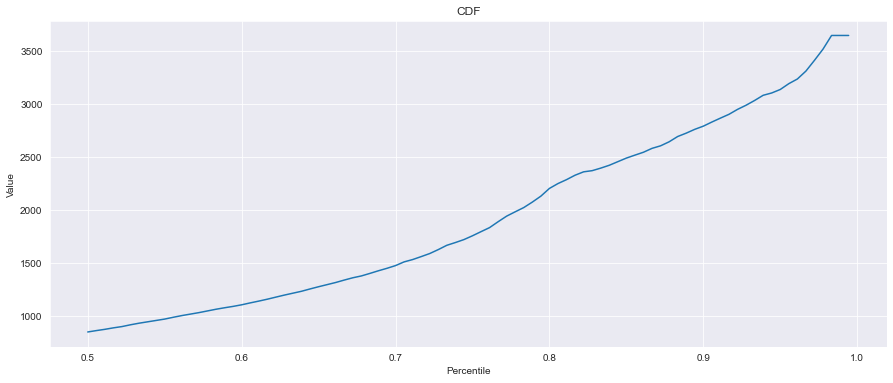

In [88]:
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
sns.kdeplot(data_high_cust['aon'],ax = ax1,shade=True)
plt.xlabel("Age on Network")
plt.title("Distribution")
plt.grid()
ax2 = plt.subplot(122)
sns.boxplot(data = data_high_cust,x = 'aon',ax=ax2,y='churn')
ax2.legend(['Churn','Not Churn'])

plt.title("BoxPlot")
plt.xlabel("Age on Network")
plt.grid()
fig.suptitle("Age on Network",size=14)
plt.show()
data_high_cust['aon'].quantile(np.linspace(0.5, 1, 90, 0)).plot(figsize=(15,6))
plt.xlabel("Percentile")
plt.ylabel("Value")
plt.title("CDF")
plt.grid()

No handles with labels found to put in legend.


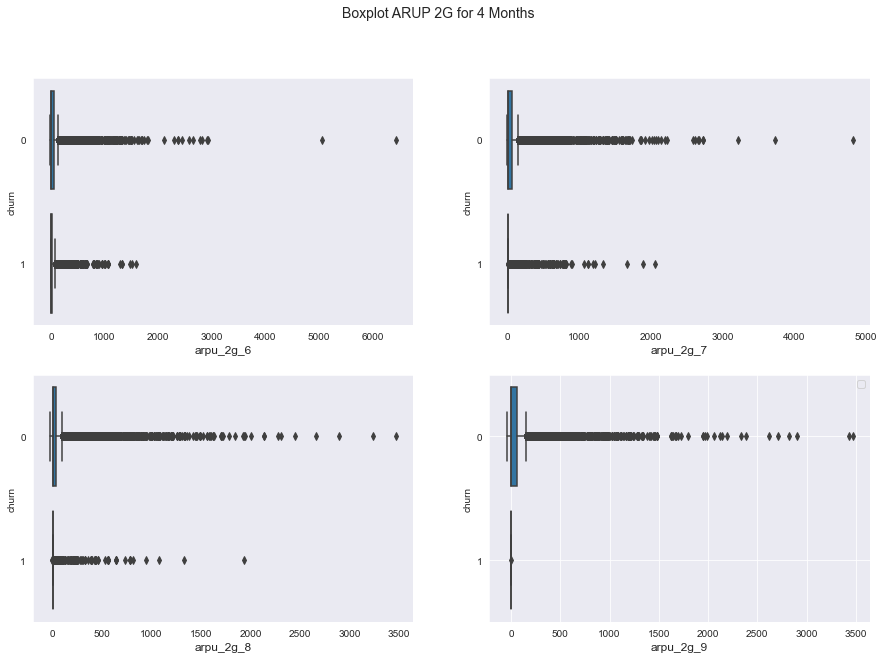

In [91]:
# Lets check the distribution on these.
# arpu_2g (Average revenue per user) for each months, looks like most of the users do not use 2G data
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distribution ARUP 2G for 4 Months",size=14)
ax1 = plt.subplot(221)
sns.boxplot(data = data_high_cust,x = 'arpu_2g_6',ax=ax1,y = 'churn')
plt.xlabel("arpu_2g_6",size=12)
ax2 = plt.subplot(222)
sns.boxplot(data = data_high_cust,x = 'arpu_2g_7',y='churn',ax=ax2)
plt.xlabel("arpu_2g_7",size=12)
ax3 = plt.subplot(223)
sns.boxplot(data = data_high_cust,x = 'arpu_2g_8',y='churn',ax=ax3)
plt.xlabel('arpu_2g_8',size=12)
ax4 = plt.subplot(224)
sns.boxplot(data = data_high_cust,x= 'arpu_2g_9',y='churn',ax=ax4)
plt.xlabel('arpu_2g_9',size=12)
plt.grid()
fig.suptitle("Boxplot ARUP 2G for 4 Months",size=14)
plt.legend()
plt.show()

In [13]:
data_high_cust = pd.read_pickle("data_with_churn.pkl")
cols = list(data_high_cust)
cols.sort()

In [45]:
# Finding out the categorical features from our data frame
def unique_values_count(data = data_high_cust,cols = cols):
    unq_feat = dict()
    for i in cols:
        unq_feat[i] = len(data[i].unique())
    new = pd.DataFrame()
    new['Feature_Names'] = unq_feat.keys()
    new['Unique_Value_Count'] = unq_feat.values()
    return new

In [15]:
new = unique_values_count()
new.head()

,Feature_Names,Unique_Value_Count
0,aon,3294
1,arpu_2g_6,5776
2,arpu_2g_7,5420
3,arpu_2g_8,4778
4,arpu_2g_9,4778


In [9]:
new.sort_values('Unique_Value_Count')

,Feature_Names,Unique_Value_Count
183,std_og_t2c_mou_9,1
53,last_date_of_month_6,1
182,std_og_t2c_mou_8,1
181,std_og_t2c_mou_7,1
180,std_og_t2c_mou_6,1
...,...,...
202,total_og_mou_7,23684
12,arpu_9,27022
11,arpu_8,28073
9,arpu_6,29072


In [16]:
# Lets start seperating categorical variables from Numerical Variables
# First lets drop all the features that does not have more than 1 unique values
categorical_features = []
col_with_1_unq_val = list(new[new.Unique_Value_Count==1]['Feature_Names'])
data_high_cust.drop(col_with_1_unq_val, axis=1, inplace=True)
data_high_cust.shape

(30001, 213)

In [17]:
def list_movement(new_list,data = categorical_features):
    for i in new_list:
        data.append(i)
    return data

In [18]:
# Lets check for variables with less than 10 unique features
categorical_features = list_movement(data = categorical_features,new_list = list(new[(new.Unique_Value_Count>1)&(new.Unique_Value_Count<=10)]['Feature_Names']))
categorical_features = [e for e in categorical_features if e not in ('churn','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9')]
# 'last_date_of_month_7','last_date_of_month_8','last_date_of_month_9':- These features could be removed from our dataset
#data_high_cust.drop(['last_date_of_month_7','last_date_of_month_8','last_date_of_month_9'],axis=1, inplace=True)

In [19]:
# Lets check for variables with  between 10 and 30 unique features
between_10_30 = list(new[(new.Unique_Value_Count>10)&(new.Unique_Value_Count<=30)]['Feature_Names'])
print(between_10_30)
categorical_features = list_movement(new_list = between_10_30,data = categorical_features)
print("="*50)
print(categorical_features)

['count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9']
['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9']


In [21]:
# Lets check for variables with between 30 and 50 unique features
between_30_50 = list(new[(new.Unique_Value_Count>10)&(new.Unique_Value_Count<=30)]['Feature_Names'])
print(between_10_30)
categorical_features = list_movement(new_list = between_10_30,data = categorical_features)
print("="*50)
print(categorical_features)

['count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9']
['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9']


In [41]:
# These are also continious variables, hence removing them
categorical_features = [e for e in categorical_features if e not in ('count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9')]

In [96]:
# These are all continious variables
list(new[(new.Unique_Value_Count>30)&(new.Unique_Value_Count<=50)]['Feature_Names'])

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'sachet_2g_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9']

In [31]:
ccc = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']
for i in ccc:
    data_high_cust[i] = pd.to_datetime(data_high_cust[i])

In [32]:
data_high_cust[ccc].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-21,2014-07-16,2014-08-08,2014-09-28,2014-06-21,2014-07-16,2014-08-08,1970-01-01
1,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-27,2014-07-25,2014-08-26,2014-09-30,1970-01-01,1970-01-01,1970-01-01,1970-01-01
2,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-25,2014-07-31,2014-08-30,2014-09-30,1970-01-01,2014-07-31,2014-08-23,1970-01-01
3,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-30,2014-07-31,2014-08-31,2014-09-30,1970-01-01,1970-01-01,1970-01-01,1970-01-01
4,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-06-18,2014-07-07,2014-08-24,2014-09-28,1970-01-01,2014-07-07,2014-08-06,2014-09-09


In [37]:
# For any user recharging there mobile device at the end of the month, the repective user will be most likely no chrun.
# However for the users recharging at the begining of the month are more likely to churn as their monthly pack could be over.
data_high_cust['days_from_rech_6'] = (data_high_cust['last_date_of_month_6'] - data_high_cust['date_of_last_rech_6']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_7'] = (data_high_cust['last_date_of_month_7'] - data_high_cust['date_of_last_rech_7']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_8'] = (data_high_cust['last_date_of_month_8'] - data_high_cust['date_of_last_rech_8']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_9'] = (data_high_cust['last_date_of_month_9'] - data_high_cust['date_of_last_rech_9']) / np.timedelta64(1, 'D')
# Data Recharge date
data_high_cust['days_from_rech_data_6'] = (data_high_cust['last_date_of_month_6'] - data_high_cust['date_of_last_rech_data_6']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_data_7'] = (data_high_cust['last_date_of_month_7'] - data_high_cust['date_of_last_rech_data_7']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_data_8'] = (data_high_cust['last_date_of_month_8'] - data_high_cust['date_of_last_rech_data_8']) / np.timedelta64(1, 'D')
data_high_cust['days_from_rech_data_9'] = (data_high_cust['last_date_of_month_9'] - data_high_cust['date_of_last_rech_data_9']) / np.timedelta64(1, 'D')

In [39]:
# Now we can drop the columns of last date and last recharge
data_high_cust.drop(ccc,axis=1,inplace=True)

In [40]:
data_high_cust.to_pickle("data_processing_after_date_of_recharge.pkl")

In [44]:
# Lets check all features with unique data between 50 and 100
# These are all continious features as well
list(new[(new.Unique_Value_Count>50)&(new.Unique_Value_Count<=100)]['Feature_Names'])

['spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'total_rech_num_9']

In [52]:
# Lets check all features with unique data between 50 and 100
# These are all continious features as well
# Now we can conclude that all these features are of continious in nature
list(new[(new.Unique_Value_Count>100)&(new.Unique_Value_Count<=1000)]['Feature_Names'])

['av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'isd_og_mou_8',
 'isd_og_mou_9',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'last_day_rch_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'og_others_9',
 'spl_ic_mou_9',
 'total_rech_num_6',
 'total_rech_num_7']

In [73]:
# Lets check date feature
date_feat_rem = []
for i in data_high_cust.columns:
    if 'date' in i:
        date_feat_rem.append(i)
if len(date_feat_rem) == 0: date_feat_rem = None
print("These are the Features that contain date format data",date_feat_rem)

These are the Features that contain date format data None


## Lets remove Outliers from our dataset

In [2]:
data_high_cust = pd.read_pickle("data_processing_after_date_of_recharge.pkl")

In [3]:
with open('y_churn.npy', 'wb') as f:
    np.save(f, data_high_cust['churn'].values)

In [23]:
# For the date feature that are being transformed to number of days to end of month. Lets check closely if there is any
# data where the number of days is above 30
# Replace all data with 0 which is greated than 30
cols_with_days = [ 'days_from_rech_6','days_from_rech_7','days_from_rech_8','days_from_rech_9','days_from_rech_data_6','days_from_rech_data_7','days_from_rech_data_8','days_from_rech_data_9']

def gret_thn_30_to_zero(arr):
    arr = np.array(arr)
    arr[arr>30] = 0
    return arr

for i in cols_with_days:
    data_high_cust[i] = gret_thn_30_to_zero(data_high_cust[i])

In [34]:
# As the below features has very few unique values, i would try to convert them into some kind of categories by binning the data
categorical_features_conversion = list(set(['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'monthly_2g_6', 'monthly_2g_7', 
     'monthly_2g_8', 'monthly_2g_9', 'night_pck_user_6', 'night_pck_user_7', 
     'night_pck_user_8', 'night_pck_user_9', 'count_rech_3g_6', 'count_rech_3g_7', 
     'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 
     'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9', 'count_rech_3g_6', 
     'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 
     'monthly_3g_9', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9',
'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9','max_rech_data_6','max_rech_data_7',
 'max_rech_data_8','max_rech_data_9','sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_2g_9','total_rech_data_6',
 'total_rech_data_7','total_rech_data_8','total_rech_data_9']))

In [46]:
new = unique_values_count(data=data_high_cust,cols=categorical_features_conversion)

In [49]:
new.sort_values('Unique_Value_Count')

,Feature_Names,Unique_Value_Count
39,fb_user_9,2
1,night_pck_user_7,2
32,night_pck_user_9,2
4,fb_user_8,2
29,fb_user_7,2
20,night_pck_user_6,2
14,night_pck_user_8,2
13,fb_user_6,2
28,monthly_2g_6,5
25,monthly_2g_9,5


In [62]:
new[(new.Unique_Value_Count>10) & (new.Unique_Value_Count<16)]

,Feature_Names,Unique_Value_Count
18,monthly_3g_7,15
19,monthly_3g_8,12
33,monthly_3g_9,11
38,monthly_3g_6,12


C:\Users\lette\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='monthly_3g_7', ylabel='count'>

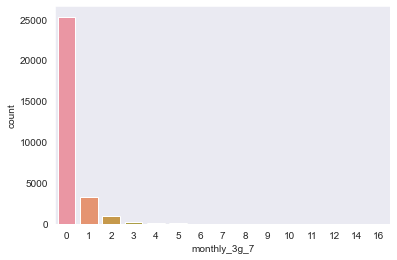

In [63]:
sns.countplot(data_high_cust['monthly_3g_7'])

In [3]:
data = pd.read_pickle('update1.pkl')

In [4]:
data.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,sep_vbc_3g,churn,days_from_rech_6,days_from_rech_7,days_from_rech_8,days_from_rech_9,days_from_rech_data_6,days_from_rech_data_7,days_from_rech_data_8,days_from_rech_data_9
0,197.385,214.816,213.803,21.100,0.00,0.00,0.00,0.00,0.00,0.00,...,3.58,1,9.0,15.0,23.0,2.0,9.0,15.0,23.0,0.0
1,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,0.00,453.43,567.16,...,0.00,1,3.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0
2,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,...,0.00,0,5.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0
3,514.453,597.753,637.760,578.596,102.41,132.11,85.14,161.63,757.93,896.68,...,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74.350,193.897,366.966,811.480,48.96,50.66,33.58,15.74,85.41,89.36,...,0.00,0,12.0,24.0,7.0,2.0,0.0,24.0,25.0,21.0


In [9]:
# After thorough analysis, the below features are found to be categorical
# 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9','night_pck_user_6', 'night_pck_user_7', 
#     'night_pck_user_8', 'night_pck_user_9',  'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9'
# but before that lets check on the numerical variables and try to see if there is any kind of correlation among them
def create_conrr(mat):
    sns.set_style("dark")
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(mat.corr().round(3), annot=True,cmap="YlGnBu")
    plt.grid()
    plt.title("Numerical Feature Correlation", size = 20)
    plt.show()

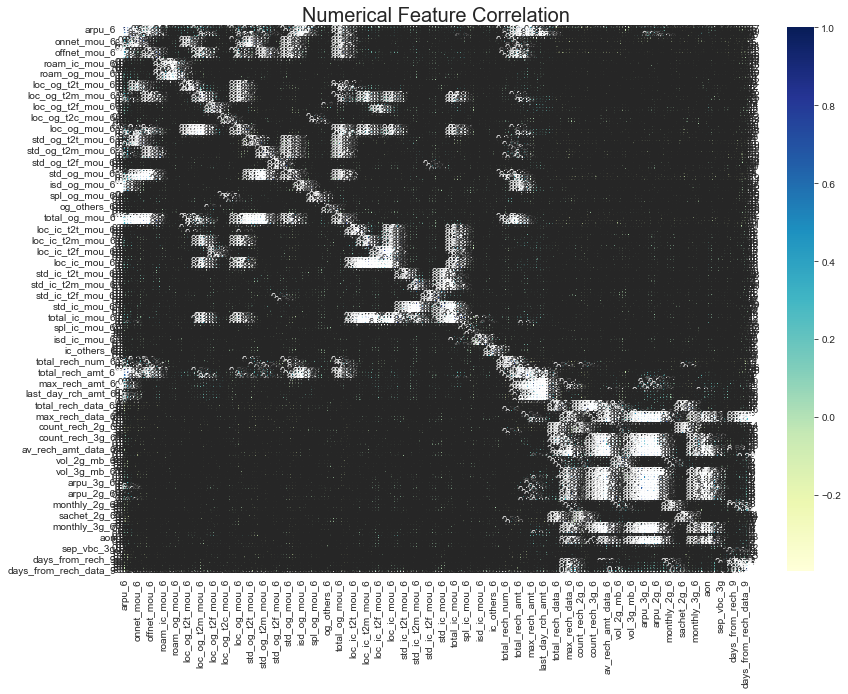

In [18]:
num_feat = [e for e in data.columns if e not in ('fb_user_6','churn', 'fb_user_7', 'fb_user_8', 'fb_user_9','night_pck_user_6', 'night_pck_user_7','night_pck_user_8', 'night_pck_user_9',  'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9')]
create_conrr(data[num_feat])

In [11]:
data[num_feat].corr().round(3)

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,jun_vbc_3g,sep_vbc_3g,days_from_rech_6,days_from_rech_7,days_from_rech_8,days_from_rech_9,days_from_rech_data_6,days_from_rech_data_7,days_from_rech_data_8,days_from_rech_data_9
arpu_6,1.000,0.672,0.613,0.565,0.342,0.216,0.187,0.177,0.509,0.339,...,0.112,0.045,-0.172,-0.037,-0.075,-0.033,-0.068,-0.088,-0.065,-0.067
arpu_7,0.672,1.000,0.760,0.684,0.212,0.321,0.270,0.228,0.352,0.490,...,0.055,0.059,-0.123,-0.179,-0.104,-0.045,-0.089,-0.073,-0.045,-0.049
arpu_8,0.613,0.760,1.000,0.797,0.152,0.234,0.348,0.285,0.279,0.377,...,0.074,0.105,-0.083,-0.167,-0.187,-0.081,-0.063,-0.041,0.001,0.006
arpu_9,0.565,0.684,0.797,1.000,0.124,0.175,0.259,0.351,0.249,0.303,...,0.081,0.153,-0.070,-0.117,-0.166,-0.145,-0.044,-0.027,0.016,0.040
onnet_mou_6,0.342,0.212,0.152,0.124,1.000,0.751,0.620,0.555,0.091,0.040,...,-0.101,-0.033,-0.174,-0.090,-0.081,-0.009,-0.130,-0.122,-0.107,-0.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
days_from_rech_9,-0.033,-0.045,-0.081,-0.145,-0.009,-0.007,-0.044,-0.106,-0.065,-0.083,...,0.023,-0.023,0.141,0.156,0.201,1.000,0.044,0.036,0.035,0.110
days_from_rech_data_6,-0.068,-0.089,-0.063,-0.044,-0.130,-0.142,-0.123,-0.115,-0.147,-0.165,...,0.182,0.040,0.357,0.149,0.114,0.044,1.000,0.362,0.280,0.245
days_from_rech_data_7,-0.088,-0.073,-0.041,-0.027,-0.122,-0.123,-0.108,-0.093,-0.135,-0.132,...,0.150,0.026,0.172,0.276,0.113,0.036,0.362,1.000,0.340,0.286
days_from_rech_data_8,-0.065,-0.045,0.001,0.016,-0.107,-0.095,-0.066,-0.066,-0.111,-0.093,...,0.147,0.033,0.123,0.099,0.204,0.035,0.280,0.340,1.000,0.352


In [41]:
corr_matrix = data[num_feat].corr().abs()
high_corr_var=np.where(corr_matrix>0.85)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
corr_feat_to_drop = []
for i in range(len(high_corr_var)):
    corr_feat_to_drop.append(high_corr_var[i][1])
high_corr_var

[('arpu_6', 'total_rech_amt_6'),
 ('arpu_7', 'total_rech_amt_7'),
 ('arpu_8', 'total_rech_amt_8'),
 ('arpu_9', 'total_rech_amt_9'),
 ('onnet_mou_6', 'std_og_t2t_mou_6'),
 ('onnet_mou_7', 'std_og_t2t_mou_7'),
 ('onnet_mou_8', 'std_og_t2t_mou_8'),
 ('onnet_mou_9', 'std_og_t2t_mou_9'),
 ('offnet_mou_7', 'std_og_t2m_mou_7'),
 ('offnet_mou_8', 'std_og_t2m_mou_8'),
 ('loc_og_mou_8', 'loc_og_mou_9'),
 ('std_og_mou_8', 'total_og_mou_8'),
 ('isd_og_mou_6', 'isd_og_mou_7'),
 ('isd_og_mou_6', 'isd_og_mou_8'),
 ('isd_og_mou_7', 'isd_og_mou_8'),
 ('isd_og_mou_7', 'isd_og_mou_9'),
 ('isd_og_mou_8', 'isd_og_mou_9'),
 ('loc_ic_mou_6', 'total_ic_mou_6'),
 ('loc_ic_mou_7', 'total_ic_mou_7'),
 ('loc_ic_mou_8', 'total_ic_mou_8'),
 ('loc_ic_mou_9', 'total_ic_mou_9'),
 ('total_rech_data_6', 'count_rech_2g_6'),
 ('total_rech_data_6', 'sachet_2g_6'),
 ('total_rech_data_7', 'count_rech_2g_7'),
 ('total_rech_data_7', 'sachet_2g_7'),
 ('total_rech_data_8', 'count_rech_2g_8'),
 ('total_rech_data_8', 'sachet_2g_8'

In [43]:
print(corr_feat_to_drop)

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'loc_og_mou_9', 'total_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_8', 'isd_og_mou_9', 'isd_og_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'count_rech_2g_6', 'sachet_2g_6', 'count_rech_2g_7', 'sachet_2g_7', 'count_rech_2g_8', 'sachet_2g_8', 'count_rech_2g_9', 'sachet_2g_9', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_2g_9', 'arpu_2g_6', 'arpu_2g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9']


In [45]:
# Lets remove these features from the numerical variables
num_feat_without_corr = [e for e in num_feat if e not in ('total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'loc_og_mou_9', 'total_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_8', 'isd_og_mou_9', 'isd_og_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'count_rech_2g_6', 'sachet_2g_6', 'count_rech_2g_7', 'sachet_2g_7', 'count_rech_2g_8', 'sachet_2g_8', 'count_rech_2g_9', 'sachet_2g_9', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_2g_9', 'arpu_2g_6', 'arpu_2g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9')]

In [46]:
len(num_feat_without_corr)

163

In [48]:
categorical_feat = ['fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9','night_pck_user_6', 'night_pck_user_7','night_pck_user_8', 'night_pck_user_9',  'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9']

In [49]:
# Lets convert the categorical features into one hot encoded numpy array
categorical_data = pd.get_dummies(data[categorical_feat],drop_first=True).values

In [53]:
# Doing log transform to get a better data as the features are heavely skewed
numerical_data = np.log(data[num_feat_without_corr]).replace([np.inf, -np.inf,np.nan],0).values

In [55]:
# concat categorical and numerical variables
new_indep_data = np.concatenate((categorical_data,numerical_data), axis=1)

In [62]:
with open('log_new_indep_data.npy', 'wb') as f:
    np.save(f, new_indep_data)

# Modeling

In [15]:
# This function will provide result to oour classification model
def validate_result(y_true, y_pred,y_prob,model="Model"):
    print(f"The Result for the {model} Classification is a Below\n")
    fig, ax = plt.subplots(figsize=(15,5))
    conf = confusion_matrix(y_true, y_pred).round(3)
    b = sns.heatmap(conf.round(3), cmap="YlGnBu",annot=True,ax = ax)
    b.axes.set_title("Confusion Matrix",fontsize=20)
    b.set_xlabel("Predicted Value",fontsize=16)
    b.set_ylabel("True Value",fontsize=16)
    b.tick_params(labelsize=16)
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted').round(3))
    print("Log Loss: ",log_loss(y_true, y_prob).round(3))
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Classification Report:\n",df.round(3))

In [9]:
new_indep_data = np.load('log_new_indep_data.npy')
churn = np.load('y_churn.npy')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(new_indep_data, churn, test_size=0.33, random_state=42)

In [65]:
# As it is a binary classifier, lets try with Logistic Regression to begin with
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='log',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=3)
log_rand.fit(new_indep_data,data['churn'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    7.9s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    7.9s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    9.3s
[Parallel(

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True, loss='log'),
                   n_jobs=3,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [66]:
log_rand.best_score_

0.9657602419451715

In [67]:
log_rand.best_estimator_

SGDClassifier(early_stopping=True, loss='log', penalty='l1')

In [71]:
clf = SGDClassifier(early_stopping=True, loss='log', penalty='l1')
clf.fit(X_train,y_train)

SGDClassifier(early_stopping=True, loss='log', penalty='l1')

The Result for the LogisticRegression Classification is a Below

Recall Score: 98.808 %
Precision Score: 98.791 %
F1 Score:  0.988
Log Loss:  0.384
Classification Report:
               precision  recall  f1-score   support
0                 0.991   0.996     0.994  9121.000
1                 0.946   0.900     0.922   780.000
accuracy          0.988   0.988     0.988     0.988
macro avg         0.969   0.948     0.958  9901.000
weighted avg      0.988   0.988     0.988  9901.000


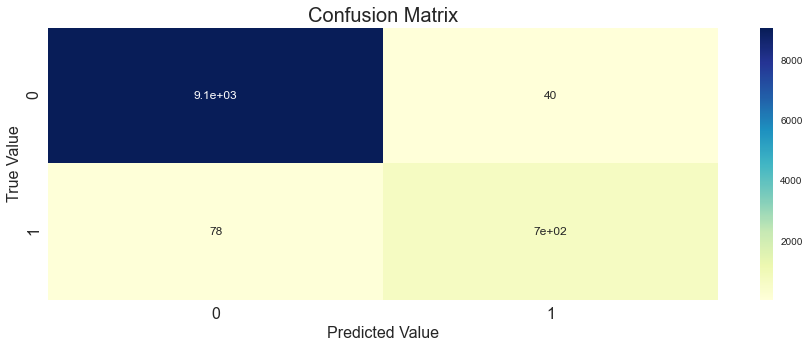

In [72]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="LogisticRegression")

C:\Users\lette\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


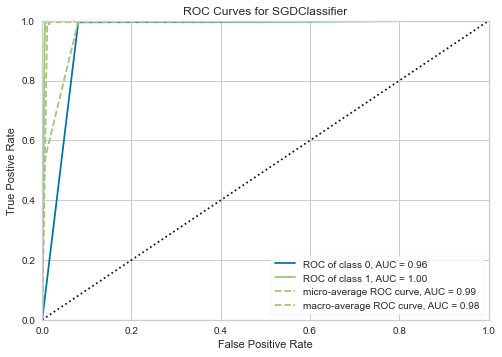

C:\Users\lette\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [73]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_cv = y_test,classes=[0,1])

### Excellent results from this approach, even without balancing the imbalanced data the results are very good.

In [74]:
# As it is a binary classifier, lets try with SVM to begin with
param = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'penalty': ['l2','l1']}

log_rand = RandomizedSearchCV(SGDClassifier(loss='hinge',early_stopping=True),param,
                              verbose=50,return_train_score=True,scoring='f1_macro',cv=5,n_jobs=3)
log_rand.fit(new_indep_data,data['churn'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    6.8s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    8.1s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    8.3s
[Parallel(

RandomizedSearchCV(cv=5, estimator=SGDClassifier(early_stopping=True), n_jobs=3,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='f1_macro', verbose=50)

In [75]:
log_rand.best_estimator_

SGDClassifier(alpha=0.01, early_stopping=True)

In [76]:
clf = SGDClassifier(alpha=0.01, early_stopping=True)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.01, early_stopping=True)

The Result for the SVM Classification is a Below

Recall Score: 99.121 %
Precision Score: 99.19 %
F1 Score:  0.991
Log Loss:  0.303
Classification Report:
               precision  recall  f1-score   support
0                 0.999   0.991     0.995  9121.000
1                 0.906   0.991     0.947   780.000
accuracy          0.991   0.991     0.991     0.991
macro avg         0.953   0.991     0.971  9901.000
weighted avg      0.992   0.991     0.991  9901.000


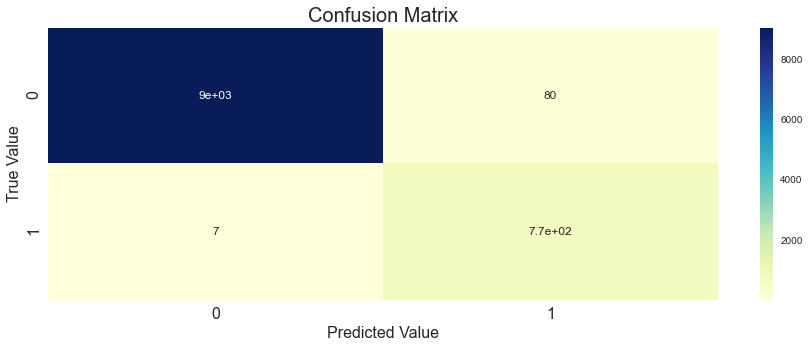

In [78]:
validate_result(y_test,clf.predict(X_test),clf.predict(X_test),model="SVM")

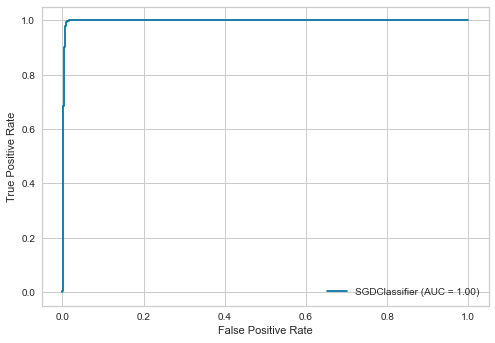

In [80]:
from sklearn import metrics
metrics.plot_roc_curve(clf, X_test, y_test)

#### As seen here, the results from Logistic Regression and SVM is very good.

### However lets try tree based algorithm to compare results

In [11]:
# RandomForest
params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
          "min_samples_leaf": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}
rf_rand = RandomizedSearchCV(RandomForestClassifier(),params,
                              verbose=8,return_train_score=True,scoring='f1_weighted',cv=10,n_jobs=5)
rf_rand.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   35.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   56.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=5,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14]},
                   return_train_score=True, scoring='f1_weighted', verbose=8)

In [12]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=12, min_samples_leaf=6)

In [13]:
clf = RandomForestClassifier(max_depth=12, min_samples_leaf=6)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=6)

The Result for the RandomForestClassifier Classification is a Below

Recall Score: 99.707 %
Precision Score: 99.718 %
F1 Score:  0.997
Log Loss:  0.013
Classification Report:
               precision  recall  f1-score   support
0                 1.000   0.997     0.998  9121.000
1                 0.964   1.000     0.982   780.000
accuracy          0.997   0.997     0.997     0.997
macro avg         0.982   0.998     0.990  9901.000
weighted avg      0.997   0.997     0.997  9901.000


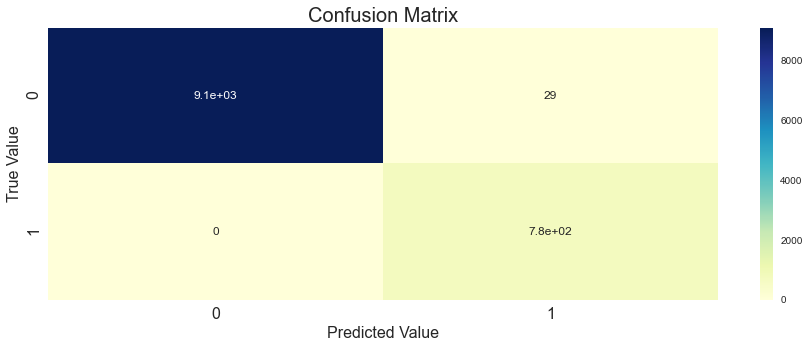

In [16]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="RandomForestClassifier")

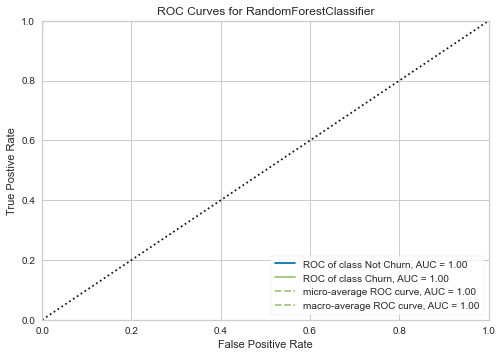

C:\Users\lette\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=['Not Churn', 'Churn'], model=None)

In [18]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_cv = y_test,classes=["Not Churn","Churn"])

#### Random Forest is giving even better results, which indicates that there are some outliers in our dataset, which needed to be handled more aggressively.

In [19]:
# XGBoost
params = {"learning_rate" : [0.00001,0.0001,0.001,0.01,0.1,1,10,100] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'subsample':[0.6, 0.7, 0.8, 0.9]}
xgb_rand = RandomizedSearchCV(XGBClassifier(),params,
                              verbose=100,return_train_score=True,scoring='f1_weighted',cv=10,n_jobs=5)
xgb_rand.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   16.8s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   16.8s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:   16.9s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:   27.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:   27.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   27.5s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:   27.9s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:   28.1s
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:   30.5s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:   30.6s
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:   31.0s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:   31.4s
[Paralle

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           verbosity=None),
                   n_jobs=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                

In [20]:
xgb_rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

The Result for the XGBoost Classification is a Below

Recall Score: 99.828 %
Precision Score: 99.831 %
F1 Score:  0.998
Log Loss:  0.006
Classification Report:
               precision  recall  f1-score   support
0                 1.000   0.998     0.999  9121.000
1                 0.980   0.999     0.989   780.000
accuracy          0.998   0.998     0.998     0.998
macro avg         0.990   0.998     0.994  9901.000
weighted avg      0.998   0.998     0.998  9901.000


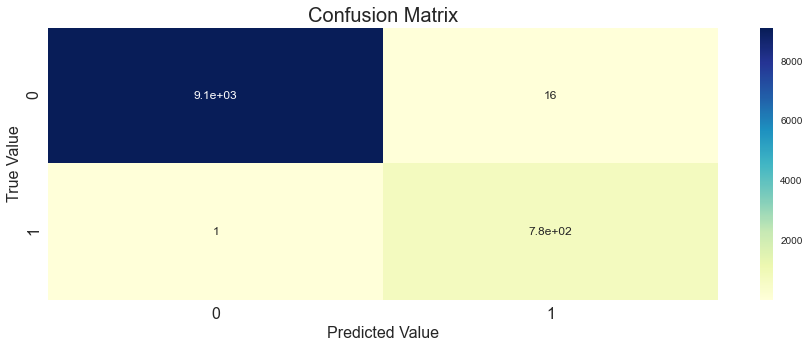

In [24]:
validate_result(y_test,clf.predict(X_test),clf.predict_proba(X_test),model="XGBoost")

C:\Users\lette\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


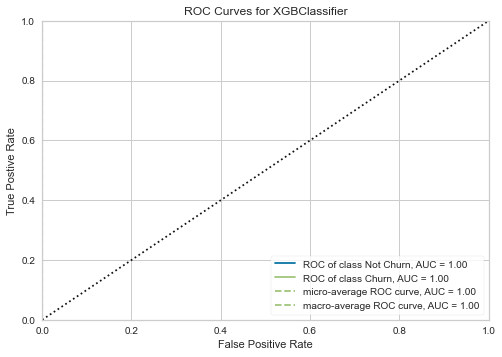

C:\Users\lette\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=['Not Churn', 'Churn'], model=None)

In [25]:
roc_auc(clf,X_train,y_train,X_test = X_test, y_cv = y_test,classes=["Not Churn","Churn"])

#### These results are very good, as we can see that ROC-AUC is giving almost result of 1. The Precision, Recall and F1 Score is also above 0.98.